In [1]:
#| include: false
import pandas as pd
import numpy as np
import pickle

import re

import itables

import warnings
warnings.filterwarnings("ignore")

import csv

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots 
from ipywidgets import interact, widgets
import plotly.offline as pyo
import plotly.io as pio

import geopandas as gpd
import shapely.geometry as sg
from shapely.geometry import MultiPolygon, Polygon
from shapely import wkt

import folium
from folium.plugins import DualMap, HeatMap

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="plotly")

from dbfread import DBF

In [2]:
#| include: false
# Year 2001
ethnicity_2001= pd.read_csv('preprocessed files/2001/ethnicity_2001.csv')
country_dissimilarity_2001 = pd.read_csv('preprocessed files/2001/country_dissimilarity_2001.csv')
LAD_dissimilarity_2001 = pd.read_csv('preprocessed files/2001/LAD_dissimilarity_2001.csv')
country_simpson_2001 = pd.read_csv('preprocessed files/2001/country_simpson_2001.csv')
LAD_simpson_2001 = pd.read_csv('preprocessed files/2001/LAD_simpson_2001.csv')
LAD_moran_2001 = pd.read_csv('preprocessed files/2001/LAD_moran_2001.csv')

LAD_2001 = gpd.read_file('preprocessed files/2001/LAD_2001.shp')

with open('preprocessed files/2001/OA_borders_2001.pkl', 'rb') as f:
    OA_borders_2001 = pickle.load(f)
with open('preprocessed files/2001/LSOA_borders_2001.pkl', 'rb') as f:
    LSOA_borders_2001 = pickle.load(f)
with open('preprocessed files/2001/MSOA_borders_2001.pkl', 'rb') as f:
    MSOA_borders_2001 = pickle.load(f)
with open('preprocessed files/2001/LAD_borders_2001.pkl', 'rb') as f:
    LAD_borders_2001 = pickle.load(f)

In [3]:
#| include: false
# Year 2011
ethnicity_2011 = pd.read_csv('preprocessed files/2011/ethnicity_2011.csv')
country_dissimilarity_2011 = pd.read_csv('preprocessed files/2011/country_dissimilarity_2011.csv')
LAD_dissimilarity_2011 = pd.read_csv('preprocessed files/2011/LAD_dissimilarity_2011.csv')
country_simpson_2011 = pd.read_csv('preprocessed files/2011/country_simpson_2011.csv')
LAD_simpson_2011 = pd.read_csv('preprocessed files/2011/LAD_simpson_2011.csv')
LAD_moran_2011 = pd.read_csv('preprocessed files/2011/LAD_moran_2011.csv')

LAD_2011 = gpd.read_file('preprocessed files/2011/LAD_2011.shp')

with open('preprocessed files/2011/OA_borders_2011.pkl', 'rb') as f:
    OA_borders_2011 = pickle.load(f)
with open('preprocessed files/2011/LSOA_borders_2011.pkl', 'rb') as f:
    LSOA_borders_2011 = pickle.load(f)
with open('preprocessed files/2011/MSOA_borders_2011.pkl', 'rb') as f:
    MSOA_borders_2011 = pickle.load(f)
with open('preprocessed files/2011/LAD_borders_2011.pkl', 'rb') as f:
    LAD_borders_2011 = pickle.load(f)

In [4]:
#| include: false
# Year 2021
ethnicity_2021= pd.read_csv('preprocessed files/2021/ethnicity_2021.csv')
country_dissimilarity_2021 = pd.read_csv('preprocessed files/2021/country_dissimilarity_2021.csv')
LAD_dissimilarity_2021 = pd.read_csv('preprocessed files/2021/LAD_dissimilarity_2021.csv')
country_simpson_2021 = pd.read_csv('preprocessed files/2021/country_simpson_2021.csv')
LAD_simpson_2021 = pd.read_csv('preprocessed files/2021/LAD_simpson_2021.csv')
LAD_moran_2021 = pd.read_csv('preprocessed files/2021/LAD_moran_2021.csv')

LAD_2021 = gpd.read_file('preprocessed files/2021/LAD_2021.shp')

with open('preprocessed files/2021/OA_borders_2021.pkl', 'rb') as f:
    OA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/LSOA_borders_2021.pkl', 'rb') as f:
    LSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/MSOA_borders_2021.pkl', 'rb') as f:
    MSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/LAD_borders_2021.pkl', 'rb') as f:
    LAD_borders_2021 = pickle.load(f)

In [5]:
#| include: false
# defining dissimilarity function
def dissimilarity(df):
    dissimilarity_results = {}
    for col in df.columns:
        col_numerator = []
        for i in range(df.shape[0]):
            col_numerator.append((df.iloc[i,:].sum() / df.sum().sum()) *
                                 np.abs((df.loc[i, col] / df.iloc[i,:].sum() - (df[col].sum() / df.sum().sum()))))
        col_numerator = sum(col_numerator)
        col_denominator = 2 * (df[col].sum() / df.sum().sum()) * (1 - (df[col].sum() / df.sum().sum()))
        dissimilarity_results[col] = round(col_numerator / col_denominator, 3)

        # print(f'dissimilarity {col} = {col_numerator/col_denominator}')
    return dissimilarity_results              

In [6]:
#| include: false
# defining simpson function

def simpson(df):
    simpson_series = []
    for i in range(df.shape[0]):
        area_ethnic_fraction_2 = []
        for col in df.columns:
            if col != 'other':
                area_ethnic_fraction_2.append((df.loc[i,col]/(df.iloc[i,:].sum()))**2)
        sum_area_ethnic_fraction_2 = sum(area_ethnic_fraction_2)
        simpson_series.append(sum_area_ethnic_fraction_2)
        
    simpson_series = pd.Series(simpson_series)
    simpson_index = 0
    for i in range(df.shape[0]):
        simpson_index += (simpson_series.iloc[i] * df.iloc[i, :].sum() / df.sum().sum())
    
    area_simpson = []
    for col in df.columns:
        if col != 'other':
            area_simpson.append((df[col].sum()/df.sum().sum())**2)
    area_simpson_index = sum(area_simpson)
    simpson_index = round(simpson_index, 3)
    area_simpson_index = round(area_simpson_index, 3)
    return [simpson_index, area_simpson_index]

In [7]:
#| include: false
# defining moran's I function

def moran(df,border):
    positive_weights = []
    for key in border.keys():
        positive_weights.append(len(border[key]))
       
    fraction = {}
    for col in df.columns:
        # df[col] = pd.to_numeric(df[col], errors='coerce')
        fraction[col] = []
        for i in df.index:
            fraction[col].append(df.loc[i, col] / df.loc[i, :].sum())
    
    col_moran = {} 
    for col in df.columns:
        col_moran_list = []
        for i in df.index:
            morani = []
            for common in border[i]:    
                morani.append(((df.loc[i, col] / df.loc[i, :].sum()) - np.mean(fraction[col])) * ((df.loc[common, col] / df.loc[common, :].sum()) - np.mean(fraction[col])))
            row_moran = sum(morani)
            col_moran_list.append(row_moran)
        col_moran[col] = col_moran_list
    moran_results= {}
    for col in df.columns:
        moran_numerator = sum(col_moran[col])*df.shape[0]
        moran_denominator = sum((fraction[col] - np.mean(fraction[col]))**2)*sum(positive_weights)
        # moran_index = moran_numerator/moran_denominator
        moran_results[col] = round(moran_numerator/moran_denominator, 3)
    return moran_results

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Introduction</span>

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Ethnic and Residenial Segregation in England</span>

- <span style="text-align: justify; font-size: 1.6em;" > Segregation, particularly residential segregation, refers to the spatial separation of different social groups within a city or metropolitan area.

- <span style="text-align: justify; font-size: 1.6em;" >Results in the clustering of individuals from similar socioeconomic backgrounds or ethnicities in distinct neighbourhoods or regions. 

- <span style="text-align: justify; font-size: 1.6em;" >Spatial separation mirrors the way societies are organized, produce and distribute resources. [@Piekut2021]

- <span style="text-align: justify; font-size: 1.6em;" >In this thesis, the ethnic segregation the England and its changes during the time will be observed.
</span>

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Data</span>


- Census data (2001, 2011 and 2021) available in geographical areas (OA, LSOA, MSOA and LAD) 

- <b>Output Areas (OA)</b> were created for Census data, specifically for the output of census estimates. The OA is the lowest geographical level at which census estimates are provided, typically encompassing approximately 300 people.

- <b>Super Output Areas (SOA)</b> are a geography hierarchy designed to improve the reporting of small-area statistics. <b>Lower Layer SOAs (LSOA)</b> has a minimum population of 1,000 and <b>Middle Layer SOAs (MSOA)</b> contains a minimum population of 5,000. LSOAs and MSOAs are of consistent size across the country and will not be subject to regular boundary change. 

- <b>Local Authority District (LAD)</b> or also known as local authority districts or local government districts (to distinguish from unofficial city districts) are a level of subnational division of England used for the purposes of local government.[@LADdef]

- Within this spatial framework, we examine the distributions of four ethnic groups. These ethnic categories stem from a larger pool of 16 to 19 groups, each representing distinct classifications based on various criteria such as country of ancestry and skin colour.[@Jones2015]. 

- <b>Census Data</b>: The dataset provides information about the ethnic group of the usual resident population of England and Wales as at census day. It contains the OA codes and the observation of ethnic groups in each OA.[@CensusData]

- <b>Lookup</b>: This file links and aggregate data at different geographic levels (e.g., from OA to larger areas like LSOAs or MSOAs) for spatial analysis.[@ShapeData]

- <b>Census boundaries (Shape Files)</b>: This file contains the polygons of boundaries of each OA.[@ShapeData]



# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Population and Ethnicity Distribution in England</span>

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Ethnic Group Fractions Over Time</span>

In [8]:
#| echo: false
#| label: fig-fracoverviewann
#| fig-cap: Ethnic Group Fractions Over Time
# Ethnic Group Fractions Over Time

country_dissimilarity_total = pd.concat([country_dissimilarity_2001, country_dissimilarity_2011, country_dissimilarity_2021], ignore_index=True)

fig = go.Figure()

# Add traces for each ethnic group fraction as stacked bars with percentage annotations outside
fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['white_frac'], 
                     name='White', legendgroup='ethnic_group', width=4, marker=dict(color='gray'),
                     text=country_dissimilarity_total['white_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))

fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['asian_frac'], 
                     name='Asian', legendgroup='ethnic_group', width=4, marker=dict(color='orange'),
                     text=country_dissimilarity_total['asian_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))

fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['black_frac'], 
                     name='Black', legendgroup='ethnic_group', width=4, marker=dict(color='black'),
                     text=country_dissimilarity_total['black_frac'] * 100, textposition='inside', 
                     texttemplate='%{text:.2f}%'))

fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['other_frac'], 
                     name='Other', legendgroup='ethnic_group', width=4, marker=dict(color='green'),
                     text=country_dissimilarity_total['other_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))



# Update layout
fig.update_layout(title_font=dict(size=16),
                  xaxis_title='Year',
                  xaxis=dict(tickvals=[2001, 2011, 2021]),
                  yaxis_title='Ethnicity Fraction',
                  yaxis=dict(
                      title='Ethnicity Fraction',
                      side='left'),
                  barmode='relative',
                  hovermode='x unified',
                #   title_text="Ethnic Group Fractions Over Time",
                #   title_x=0.5,
                #   title_y=0.96,
                  width=900,
                  height=500,
                  legend=dict(orientation="h",
                              yanchor="top",
                              y=1.17,
                              xanchor="center",
                              x=0.5,
                              traceorder='normal'))

# Display the figure
pyo.iplot(fig)


## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Ethnicity and Total Population Line Chart
</span>

In [9]:
#| echo: false
#| label: fig-popethnicann
#| fig-cap: Ethnicity and Total Population Line Chart
# Ethnicity and Total Population Line Chart

population_df = pd.concat([
    pd.DataFrame(ethnicity_2001[['white', 'asian', 'black', 'other']].sum(), columns=['population'])
    .reset_index().rename(columns={'index': 'ethnicity'}).assign(year=2001),
    pd.DataFrame(ethnicity_2011[['white', 'asian', 'black', 'other']].sum(), columns=['population'])
    .reset_index().rename(columns={'index': 'ethnicity'}).assign(year=2011),
    pd.DataFrame(ethnicity_2021[['white', 'asian', 'black', 'other']].sum(), columns=['population'])
    .reset_index().rename(columns={'index': 'ethnicity'}).assign(year=2021)
])


# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Ethnicity Population", "Total Population"),
                     vertical_spacing=0.15)

# Add traces for ethnicity populations
offsets = {
    'white': (0, 30),
    'asian': (0, -30),
    'black': (-30, 0),
    'other': (0, 30)
}

for ethnicity in population_df['ethnicity'].unique():
    trace = go.Scatter(
        x=population_df[population_df['ethnicity'] == ethnicity]['year'],
        y=population_df[population_df['ethnicity'] == ethnicity]['population'],
        mode='lines+markers',
        name=ethnicity,
        legendgroup=ethnicity 
    )
    fig.add_trace(trace, row=1, col=1)
    
    # Add annotations with custom offsets for each ethnicity
    for i, row in population_df[population_df['ethnicity'] == ethnicity].iterrows():
        ax, ay = offsets.get(ethnicity, (0, 0)) 
        fig.add_annotation(
            x=row['year'],
            y=row['population'],
            text=f"{row['population']:,}",
            showarrow=True,
            arrowhead=0,
            ax=ax,
            ay=ay,
            font=dict(size=10),
            xanchor='center',
            yanchor='bottom',
            row=1,
            col=1
        )

# Add trace for total population in the second subplot
total_population_trace = go.Scatter(
    x=country_dissimilarity_total['year'],
    y=country_dissimilarity_total['total_population'],
    mode='lines+markers',
    name='Total Population',
    line=dict(color='black')
)
fig.add_trace(total_population_trace, row=1, col=2)

# Add annotations for total population
for i, row in country_dissimilarity_total.iterrows():
    fig.add_annotation(
        x=row['year'],
        y=row['total_population'],
        text=f"{row['total_population']:,}",
        showarrow=True,
        arrowhead=0,
        ax=0,
        ay=-20,
        font=dict(size=10),
        xanchor='center',
        yanchor='bottom',
        row=1,
        col=2
    )

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Ethnicity Population", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Total Population", row=1, col=2)

# Update layout
fig.update_layout(
    height=400, 
    width=1000, 
    # title_text="Ethnicity and Total Population Line Chart",
    # title_x=0.5,
    # title_y=0.96,
    showlegend=True,
    legend=dict(orientation="h", yanchor="top", y= 1.28, xanchor="center", x=0.5)
)

# Display the figure
pyo.iplot(fig)

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Dissimilarity Index</span>

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Definition</span>
<p style="text-align: justify;" >

- A demographic measure of the evenness

- Score between 0 and 1, 0 reflects a fully integrated environment; a score of 1 reflects full segregation

- Example: In terms of black–white segregation, a score of 0.60 means that 60 percent of blacks would have to exchange places with whites in other units to achieve an even geographic distribution. [@DissimilarityDef]

<p style="text-align: justify;" >
This index is calculated using the following formula: 

$$ 
D^X = \frac{\sum_{i} \frac{N_i}{N_{\text{Area}}}|P_i^X - P_{\text{Area}}^X|}{2P_{\text{Area}}^X(1-P_{\text{Area}}^X)}\ 
$$

$P_i^X$: Fraction of individuals for ethnic group $X$ in $sub\_area_i$

$P_{\text{Area}}^X$: Fraction in the whole area

$N_i$: Number of individuals in $sub\_area_i$ 

$N_{\text{Area}}$: Number of individuals in the whole geographical area

The denominator is to normalize the Dissimilarity index to lie between zero and one.[@Zuccotti2023]

In [10]:
#| include: false
dissimilarity_visualisation = country_dissimilarity_total.melt(id_vars=['year'], value_vars= country_dissimilarity_total.columns[6:], 
                           var_name='level_ethnic', value_name='dissimilarity')
dissimilarity_visualisation['level'] = dissimilarity_visualisation['level_ethnic'].apply(lambda x: x.split('_')[0]) 
dissimilarity_visualisation['ethnicity'] = dissimilarity_visualisation['level_ethnic'].apply(lambda x: x.split('_')[1]) 
dissimilarity_visualisation.drop(columns = ['level_ethnic'], axis = 1, inplace= True)
# dissimilarity_visualisation = dissimilarity_visualisation.pivot(index = ['level','year'], columns = 'ethnicity', values = 'dissimilarity').reset_index().rename_axis(None, axis=1)
# dissimilarity_visualisation

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Dissimilarity Index Variation Over the Time Across Geographic Levels</span>

In [11]:
#| echo: false
#| label: fig-dissvaryear
#| fig-cap: Dissimilarity Index Variation Over the Time Across Geographic Levels

fig = make_subplots(rows=1, cols=4, subplot_titles=dissimilarity_visualisation['level'].unique(),
                    horizontal_spacing=0.02, print_grid= False, shared_yaxes= True)
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

colors = ['gray', 'orange', 'black','green'] 

for i, level in enumerate(dissimilarity_visualisation['level'].unique(), 1):
    level_data = dissimilarity_visualisation[dissimilarity_visualisation['level'] == level] 
    traces= []
    for j, ethnic in enumerate(level_data['ethnicity'].unique()):
        line_data = level_data[level_data['ethnicity']==ethnic]
        show_legend = (i == 1) 
        color = colors[j]
        traces.append(go.Scatter(x=line_data['year'].unique(), 
                                 y=line_data['dissimilarity'], mode='lines+markers', 
                                 name=ethnic, line=dict(color=color),
                                 showlegend= show_legend)
                       )
        
    for trace in traces:
        fig.add_trace(trace, row=1, col=i)

fig.update_layout(height=400,
                  width=1000,
                #   title_text= 'Dissimilarity Index Variation Over the Time Across Geographic Levels',
                #   title_font=dict(size=16),
                #   title_x=0.5,
                  legend=dict(orientation="h",
                      yanchor="top",
                      y=1.22,
                      xanchor="center",
                      x=0.5,
                      traceorder='normal')
)

for i in range(1, 5):
    fig.update_xaxes(tickvals=level_data['year'].unique(), row=1, col=i)
fig.update_yaxes(title_text="Dissimilarity Index", row=1, col=1, title_font=dict(size=12))

# fig.show()
pyo.iplot(fig)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Dissimilarity Box-Plot at LAD Level</span>

In [12]:
#| echo: false
#| label: fig-laddissbox
#| fig-cap: Dissimilarity Index Box-Plot by Ethnicity and Geographical Levels
# Dissimilarity Index Box-Plot by Ethnicity and Geographical Levels
LAD_dissimilarity_total = pd.concat([LAD_dissimilarity_2001, LAD_dissimilarity_2011, LAD_dissimilarity_2021], ignore_index=True)

fig = make_subplots(rows=3, cols=3,
                    vertical_spacing=0.07, horizontal_spacing=0.03,
                    subplot_titles=("white-OA", "white-LSOA", "white-MSOA",
                                    "asian-OA", "asian-LSOA", "asian-MSOA",
                                    "black-OA", "black-LSOA", "black-MSOA",
                                    # "other-OA", "other-LSOA", "other-MSOA",
                                    ))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)
    
years = ['2001', '2011', '2021']
areas = ['OA', 'LSOA', 'MSOA']
box_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']
ethnicities = ['white', 'asian', 'black',
            #    'other'
               ]

# Define y-axis ranges for each area
y_ranges = {'OA': [0.01, 1.1], 'LSOA': [-0.03, 0.85], 'MSOA': [-0.03, 0.8]}

for row, ethnicity in enumerate(ethnicities, start=1):
    for col, area in enumerate(areas, start=1):
        for j, year in enumerate(years):
            show_legend = True if col == 1 and row == 1 else False
            df = LAD_dissimilarity_total[LAD_dissimilarity_total['year'] == int(year)]
            hover_text = df['LADNM'] 
            fig.add_trace(go.Box(y=df[f'{area}_{ethnicity}'], 
                                 name=f'{year}', 
                                 hovertext=hover_text,
                                #  boxpoints='all',
                                 showlegend=show_legend, 
                                 marker=dict(color=box_colors[j])),
                          row=row, col=col)
    # Update y-axis range for each row and area
    for col, area in enumerate(areas, start=1):
        fig.update_yaxes(range=y_ranges[area], row=row, col=col)

fig.update_layout(height=800,
                  width=1000,
                #   title_text="Dissimilarity Index Box-Plot by Ethnicity and Area",
                #   title_x=0.5,
                #   title_y=0.97,
                #   title_font=dict(size=16),
                  legend=dict(orientation="h",
                      yanchor="top",
                      y=1.075,
                      xanchor="center",
                      x=0.5))

for i in range(1, 5):
    fig.update_yaxes(title_text="Dissimilarity Index", row=i, col=1, title_font=dict(size=12))
# fig.show()
pyo.iplot(fig)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Dissimilarity on Map</span>

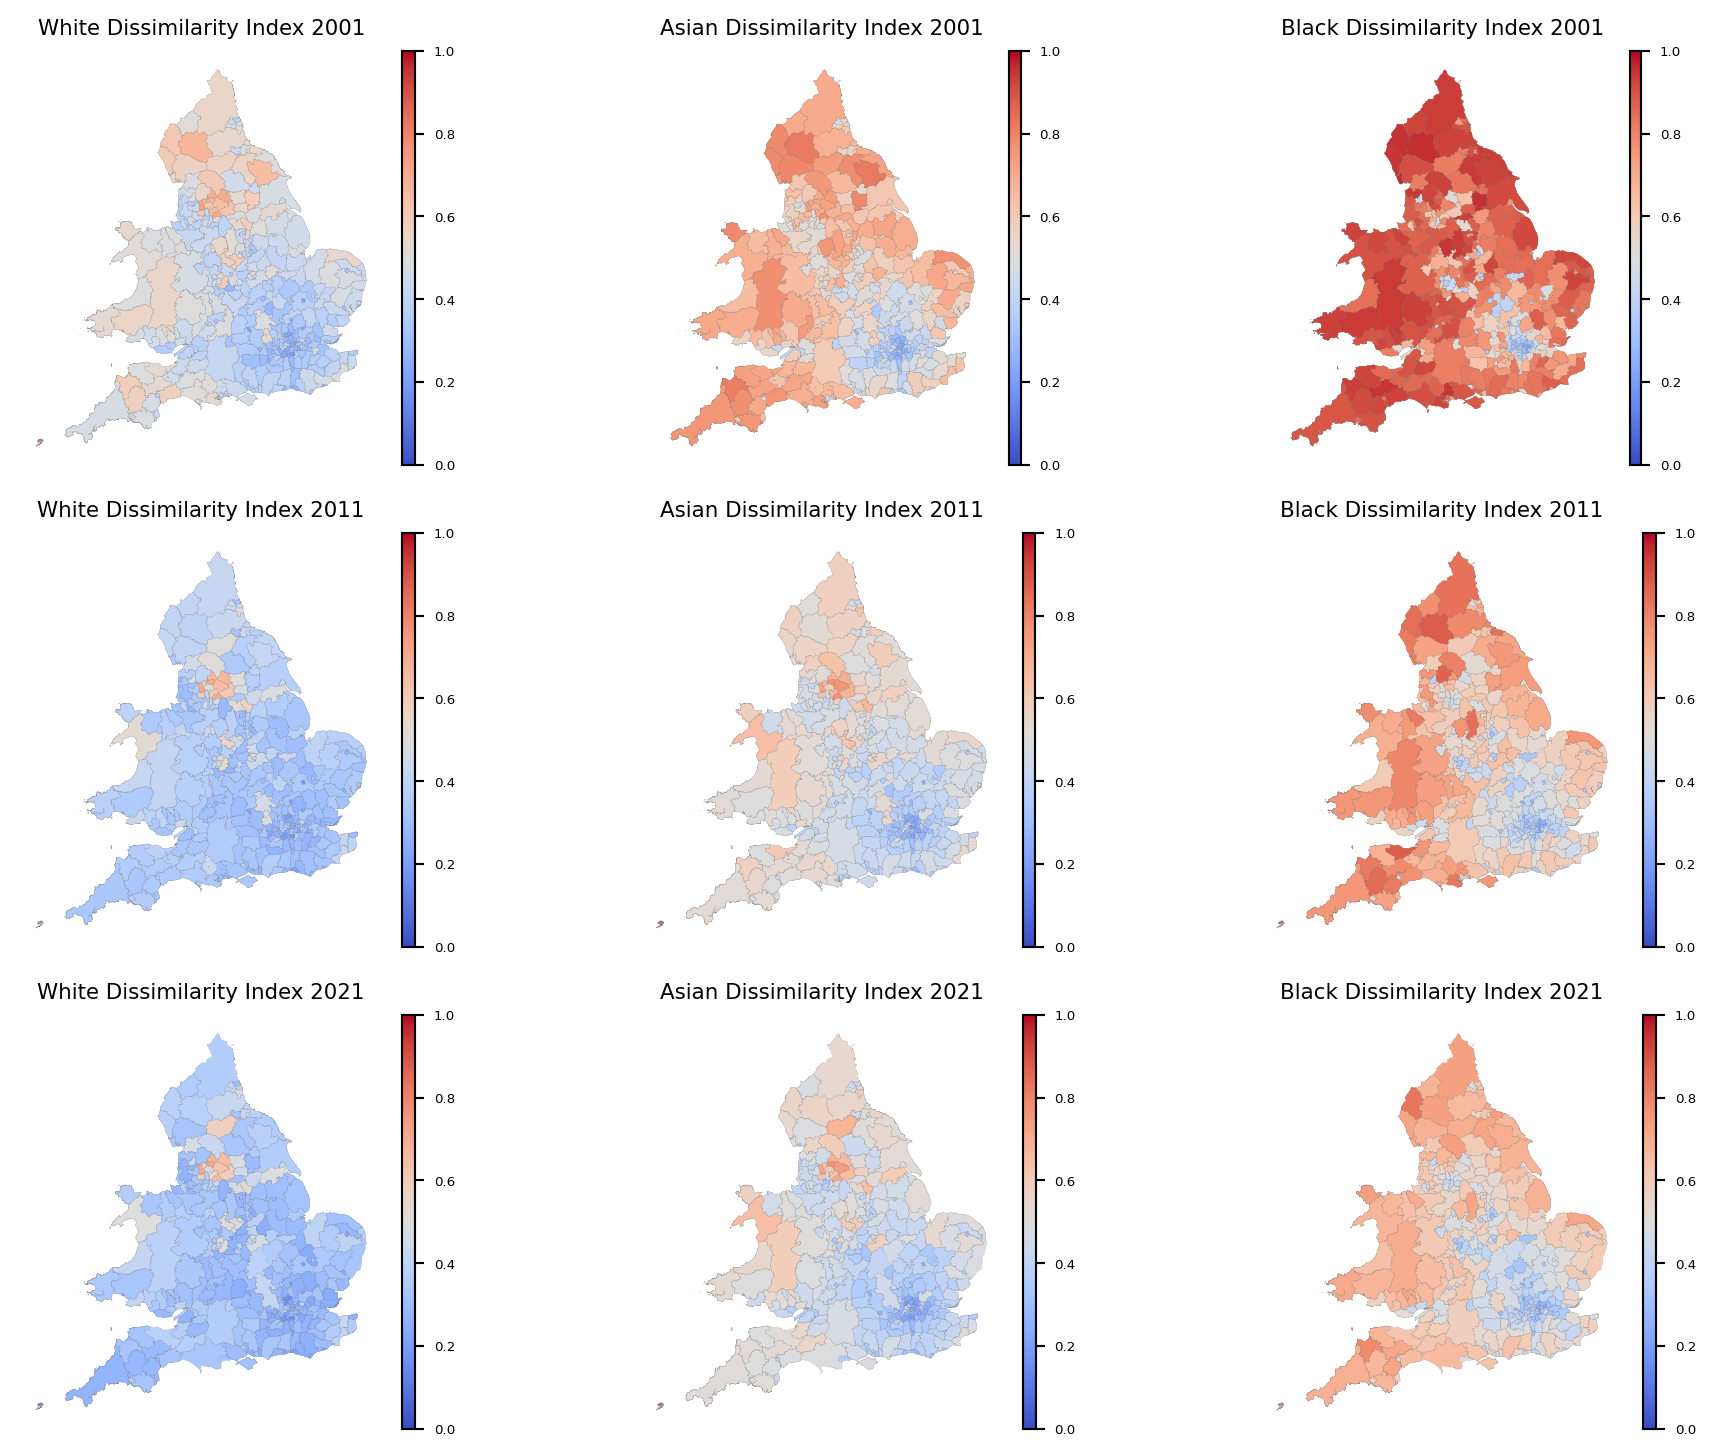

In [13]:
#| echo: false
#| label: fig-ladoadissmap
#| fig-cap: OA-based Dissimilarity Index for all ethnic groups in LADs

area = 'OA'
years = [2001, 2011, 2021]
map_data = pd.merge(LAD_dissimilarity_total, pd.concat([LAD_2001, LAD_2011, LAD_2021])[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

# Reverse the colormap for the last column
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    (f'{area}_white', 0, 1, 'White Dissimilarity Index', 'coolwarm'),
    (f'{area}_asian', 0, 1, 'Asian Dissimilarity Index', 'coolwarm'),
    (f'{area}_black', 0, 1, 'Black Dissimilarity Index', 'coolwarm'),
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = map_data[map_data['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 3 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=0.1)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
        
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=8)
        ax.axis('off')

# fig.suptitle(f'{area}-based Dissimilarity Index for all ethnic groups in LADs', fontsize=9, y=0.97)

# Adjust layout
plt.subplots_adjust(hspace=0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Simpson Index</span>

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Definition</span>
<p style="text-align: justify;" >

- A measure of ethnic concentration

- Score between 0 and 1

- Expresses the probability that two randomly selected individuals from the geographic area have the same ethnicity. 

This Average Local Simpson Index is calculated using the following formula: 

$$ 
S = {\sum_{i} (\frac{N_i} {N_{\text{Area}}} {\sum_{X} (P_i^X)^2})}
$$

- $S_i = {\sum_{X} (P_i^X)^2}$: Simpson Index for each $sub\_area_i$

- The lower $S_i$, the more ethnically diverse 

- The maximal value is achieved when the district is populated exclusively by one ethnic group.

- To calculate this index, “Other” ethnic groups is left outside. It has been done upon the consideration that individuals from this group are less likely to recognize each other as similar in terms of ethnic preferences.[@Zuccotti2023]

In [14]:
#| include: false
country_simpson_total = pd.concat([country_simpson_2001, country_simpson_2011, country_simpson_2021], ignore_index=True)

In [15]:
#| include: false
simpson_visualisation = country_simpson_total.melt(id_vars=['year'], value_vars= country_simpson_total.columns[-5:], 
                           var_name='level', value_name='simpson_index')

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Simpson Index Line Chart at Country Level</span>

In [16]:
#| echo: false
#| label: fig-simpcount
#| fig-cap: Simpson Index Line Chart at Country Level

traces = []
for level in simpson_visualisation['level'].unique():
    trace = go.Scatter(
        x= simpson_visualisation[simpson_visualisation['level'] == level]['year'],
        y= simpson_visualisation[simpson_visualisation['level'] == level]['simpson_index'],
        mode='lines+markers',
        name=level
    )
    traces.append(trace)

layout = go.Layout(height = 400,
                    width = 800,
                    # title_text="Simpson Index Line Chart at Country Level",
                    # title_x=0.5,
                    # title_font=dict(size=16),
                    xaxis=dict(title='Year', tickvals=simpson_visualisation['year'].unique()),
                    yaxis=dict(title='Simpson Index'),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5),
                    hovermode='closest',
                    showlegend=True
)


fig = go.Figure(data=traces, layout=layout)

# fig.show()
pyo.iplot(fig)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Simpson Index Box-Plot across the years</span>
For each LAD, OAs, LSOAs, and MSOAs were considered as the subareas of interest.

In [17]:
#| include: false
# computing the difference columns
LAD_simpson_total = pd.concat([LAD_simpson_2001, LAD_simpson_2011, LAD_simpson_2021], ignore_index=True)
LAD_simpson_total['OA_LAD_diff']= LAD_simpson_total['OA']- LAD_simpson_total['LAD']
LAD_simpson_total['LSOA_LAD_diff']= LAD_simpson_total['LSOA']- LAD_simpson_total['LAD']
LAD_simpson_total['MSOA_LAD_diff']= LAD_simpson_total['MSOA']- LAD_simpson_total['LAD']

In [18]:
#| echo: false
#| label: fig-simpbox
#| fig-cap: Simpson Index Box-Plot across the years
# Simpson Index Box-Plot across the years
fig = make_subplots(rows=1, cols=4, subplot_titles=("OA", "LSOA", "MSOA", "LAD"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

years= ["2001", "2011", "2021"]
box_colors = ['#636EFA','#EF553B','#00CC96','#AB63FA']
areas= ["OA", "LSOA", "MSOA", "LAD"]

for i, area  in enumerate(areas, start=1):
    for j, year in enumerate(years):
        show_legend = False if i != 1 else True 
        df = LAD_simpson_total[LAD_simpson_total['year'] == int(year)]
        hover_text = df['LADNM'] 
        fig.add_trace(go.Box(y=df[area], 
                                name=f'{year}', 
                                # boxpoints='all',
                                hovertext=hover_text, 
                                showlegend=show_legend, marker=dict(color=box_colors[j])), row=1, col=i)


fig.update_layout(height=400,
                    width=1000,
                    # title_text='Simpson Index Box-Plot across the years',
                    # title_x=0.5,
                    # title_y=0.95,
                    title_font=dict(size=16),
                    
                    yaxis=dict(title='Simpson Index'),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5)
)
for i in range(1, 5):
    fig.update_yaxes(range=[0.24, 1.01], row=1, col=i)

# fig.show()
pyo.iplot(fig)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > Differences between Simpson Index at LAD and OA level </span>

In [19]:
#| echo: false
#| label: fig-simpdiffbox
#| fig-cap: Differences between Simpson Index at LAD and OA level
# Differences between Simpson Index at LAD and OA level

fig = make_subplots(rows=1, cols=3, subplot_titles=("LAD_OA", "LAD_LSOA", "LAD_MSOA"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)
    
years= ["2001", "2011", "2021"]
box_colors = ['#636EFA','#EF553B','#00CC96','#AB63FA']
areas= ["OA_LAD_diff", "LSOA_LAD_diff", "MSOA_LAD_diff"]

for i, area  in enumerate(areas, start=1):
    for j, year in enumerate(years):
        show_legend = False if i != 1 else True 
        df = LAD_simpson_total[LAD_simpson_total['year'] == int(year)]
        hover_text = df['LADNM'] 
        fig.add_trace(go.Box(y=df[area], 
                                name=f'{year}', 
                                hovertext=hover_text, 
                                showlegend=show_legend, marker=dict(color=box_colors[j])), row=1, col=i)
    
fig.update_layout(height=400,
                    width=1000,
                    # title_text='Differences between Simpson Index at LAD and OA level',
                    # title_x=0.5,
                    # title_font=dict(size=16),
                    yaxis=dict(title='Simpson Index Difference'),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5)
)
for i in range(1, 4):
    fig.update_yaxes(range=[-0.01, 0.28], row=1, col=i)

# fig.show()
pyo.iplot(fig)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > Difference of LAD-OA Simpson Indices on Map of England </span>

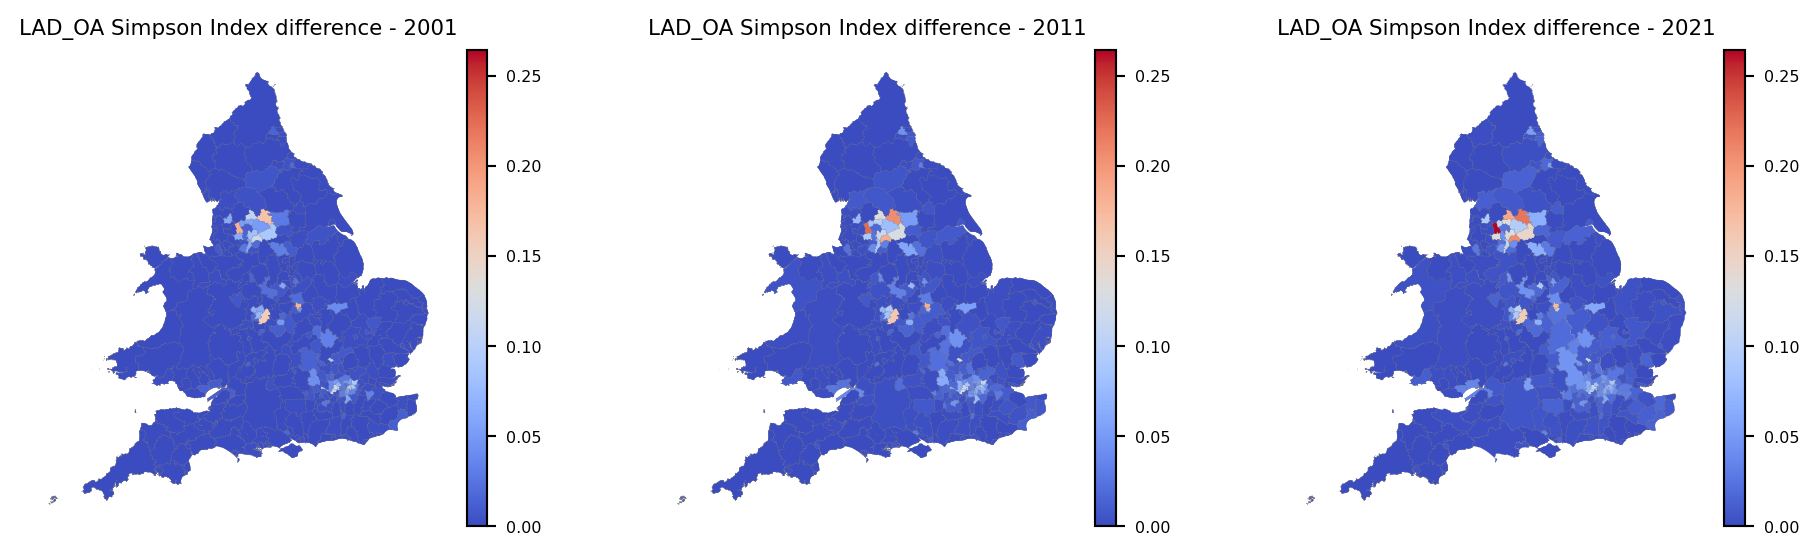

In [20]:
#| echo: false
#| label: fig-simpdiffmap
#| fig-cap: Difference of LAD-OA Simpson Indices on Map of England
# Difference of LAD-OA Simpson Indices on Map of England

years = [2001, 2011, 2021]

# Assuming LAD_simpson_total contains the Simpson index data
LAD_simpson_min, LAD_simpson_max = LAD_simpson_total['OA_LAD_diff'].min(), LAD_simpson_total['OA_LAD_diff'].max()

# Merge the Simpson index data with geometries from different years
map_data = pd.merge(LAD_simpson_total, pd.concat([LAD_2001, LAD_2011, LAD_2021])[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

# Loop through years and columns to plot the maps
for ax, year in zip(axes, years):
    # Filter data for the given year
    data_year = map_data[map_data['year'] == year]

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    data_year.plot(column='OA_LAD_diff', cmap='coolwarm', linewidth=0.05, ax=ax, edgecolor='0.5',
                   vmin=LAD_simpson_min, vmax=LAD_simpson_max, legend=False, cax=cax)
   
    # Manually create the colorbar
    norm = plt.Normalize(vmin=LAD_simpson_min, vmax=LAD_simpson_max)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.tick_params(labelsize=6)

    ax.set_title(f'LAD_OA Simpson Index difference - {year}', fontsize=8)
    ax.axis('off')

# fig.suptitle('Difference of LAD-OA Simpson Indices on Map of England', fontsize=9, y=1)

# Adjust layout
plt.tight_layout()
plt.show()

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Moran's I Index</span>

In [21]:
#| include: false
# Calculating Moran's I Iindex for country level, considering LAD as sub area
Moran_2001 = moran(ethnicity_2001.groupby(['LAD01CD'])[['white' , 'asian' , 'black','other']].sum()[['white' , 'asian' , 'black','other']],LAD_borders_2001)

Moran_2011 = moran(ethnicity_2011.groupby(['LAD11CD'])[['white' , 'asian' , 'black','other']].sum()[['white' , 'asian' , 'black','other']],LAD_borders_2011)

Moran_2021 = moran(ethnicity_2021.groupby(['LAD21CD'])[['white' , 'asian' , 'black','other']].sum()[['white' , 'asian' , 'black','other']],LAD_borders_2021)


In [22]:
#| include: false
# Country Level Moran's I IIndex in 3 years
Moran_2001['year'] = 2001
Moran_2011['year'] = 2011
Moran_2021['year'] = 2021
country_moran_total = pd.DataFrame([Moran_2001, Moran_2011, Moran_2021])
column_order= ["year", "white", "asian", "black", "other"]
country_moran_total = country_moran_total[column_order]

country_moran_total = country_moran_total.rename(columns={col: f'{col}_moran' for col in ["white", "asian", "black", "other"]})

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > Moran's I Index Variation Across the Year </span>

In [23]:
#| echo: false
#| label: fig-morcount
#| fig-cap: Moran's I Is IIndex Variation Across the Year
# Moran's I Variation Across the Years

colors = ['darkgray', 'orange', 'black', 'green']
ethnicity = ['white_moran', 'asian_moran', 'black_moran', 'other_moran']
fig = make_subplots(rows=1, cols=2, shared_xaxes=True, subplot_titles=("Bar Chart", "Line Chart"))

bar_traces = []
for i, ethnic in enumerate(ethnicity):
    trace = go.Bar(
        x=country_moran_total['year'],
        y=country_moran_total[ethnic],
        name=ethnic,
        marker=dict(color=colors[i])
    )
    bar_traces.append(trace)

line_traces = []
for i, ethnic in enumerate(ethnicity):
    trace = go.Scatter(
        x=country_moran_total['year'],
        y=country_moran_total[ethnic],
        name=ethnic,
        mode='lines+markers',
        line=dict(color=colors[i], width=2)
    )
    line_traces.append(trace)

for trace in bar_traces:
    fig.add_trace(trace, row=1, col=1)

for trace in line_traces:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(width=1000,
                    height=400,
                    # title_text= "Moran's I Index Variation Across the Year",
                    # title_font=dict(size=16),
                    # title_x=0.5,
                    # title_y=0.97,
                    yaxis=dict(title="moran's I Index"),
                    
                    legend=dict(orientation="h",
                        yanchor="top",
                        y=1.31,
                        xanchor="center",
                        x=0.5,
                        traceorder='normal')
)
for i in range (1,3):
    fig.update_xaxes(tickvals=country_moran_total['year'], row=1, col=i)


pyo.iplot(fig)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > Moran's I at LAD level </span>
<p style="text-align: justify;" >
The NaN value for each subarea's Moran’s I indicates subareas with a population count of zero for a specific ethnicity.
</p>

In [24]:
#| Include: false
# Moran's I Variation Across the Years
LAD_moran_total = pd.concat([LAD_moran_2001, LAD_moran_2011, LAD_moran_2021], ignore_index= True)
LAD_moran_total= LAD_moran_total.rename(columns={col:f'{col}_mor' for col in ['OA_white', 'LSOA_white', 'MSOA_white',
       'OA_asian', 'LSOA_asian', 'MSOA_asian', 'OA_black', 'LSOA_black',
       'MSOA_black', 'OA_other', 'LSOA_other', 'MSOA_other']})

In [25]:
#| include: false
pd.concat([LAD_moran_total[LAD_moran_total['year']==2001].sort_values('LSOA_white_mor',ascending= False).head(5),
LAD_moran_total[LAD_moran_total['year']==2011].sort_values('LSOA_white_mor',ascending= False).head(5),
LAD_moran_total[LAD_moran_total['year']==2021].sort_values('LSOA_white_mor',ascending= False).head(5)]).reset_index(drop= True)

year       LADNM      LADCD  LAD_population  white_frac  asian_frac  \
0   2001  Birmingham  E08000025          977057       0.704       0.207   
1   2001     Croydon  E09000008          330688       0.701       0.128   
2   2001   Redbridge  E09000026          238511       0.636       0.265   
3   2001     Enfield  E09000010          273616       0.771       0.094   
4   2001      Ealing  E09000009          300886       0.587       0.289   
5   2011  Birmingham  E08000025         1073045       0.579       0.266   
6   2011     Croydon  E09000008          363378       0.551       0.164   
7   2011       Derby  E06000015          248752       0.803       0.125   
8   2011     Enfield  E09000010          312466       0.610       0.112   
9   2011    Hounslow  E09000018          253957       0.514       0.344   
10  2021  Birmingham  E08000025         1144951       0.486       0.310   
11  2021       Derby  E06000015          261338       0.738       0.157   
12  2021   Leicester  E06000016          368531       0.409       0.434   
13  2021    Bradford  E08000032          546416       0.611       0.321   
14  2021     Croydon  E09000008          390701       0.484       0.175   

    black_frac  other_frac  OA_white_mor  LSOA_white_mor  MSOA_white_mor  \
0        0.061       0.029         0.926           0.920           0.793   
1        0.133       0.037         0.869           0.919           0.853   
2        0.076       0.024         0.881           0.850           0.648   
3        0.105       0.030         0.785           0.849           0.676   
4        0.088       0.036         0.835           0.846           0.636   
5        0.090       0.065         0.921           0.919           0.820   
6        0.202       0.083         0.870           0.902           0.828   
7        0.029       0.043         0.884           0.866           0.611   
8        0.172       0.106         0.831           0.861           0.718   
9        0.066       0.076         0.852           0.844           0.793   
10       0.110       0.094         0.898           0.905           0.820   
11       0.040       0.065         0.895           0.875           0.674   
12       0.078       0.079         0.896           0.855           0.693   
13       0.020       0.047         0.902           0.849           0.666   
14       0.226       0.115         0.791           0.841           0.764   

    OA_asian_mor  LSOA_asian_mor  MSOA_asian_mor  OA_black_mor  \
0          0.892           0.878           0.710         0.761   
1          0.740           0.801           0.640         0.832   
2          0.850           0.819           0.633         0.577   
3          0.578           0.717           0.522         0.780   
4          0.860           0.876           0.627         0.478   
5          0.881           0.874           0.727         0.718   
6          0.737           0.753           0.539         0.816   
7          0.851           0.819           0.562         0.543   
8          0.480           0.677           0.479         0.835   
9          0.860           0.863           0.819         0.285   
10         0.868           0.870           0.736         0.685   
11         0.846           0.821           0.626         0.491   
12         0.897           0.866           0.721         0.524   
13         0.876           0.820           0.629         0.496   
14         0.692           0.708           0.467         0.696   

    LSOA_black_mor  MSOA_black_mor  OA_other_mor  LSOA_other_mor  \
0            0.835           0.774         0.363           0.557   
1            0.907           0.894         0.253           0.488   
2            0.641           0.551         0.104           0.144   
3            0.857           0.696         0.222           0.461   
4            0.364           0.135         0.204           0.347   
5            0.750           0.670         0.522           0.676   
6            0.882           0.852         0.431     

In [26]:
#| echo: false
#| label: fig-mornbox
#| fig-cap: OA-based Moran's I in LADs for Ethnicities across the years
# OA-based Moran's I in LADs for Ethnicities across the years

fig = make_subplots(rows=1, cols=4, subplot_titles=("White", "Asian", "Black", "Other"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

years= ["2001", "2011", "2021"]
box_colors = ['#636EFA','#EF553B','#00CC96','#AB63FA']
ethnicities= ["OA_white_mor", "OA_asian_mor", "OA_black_mor", "OA_other_mor"]

for i, ethnicity  in enumerate(ethnicities, start=1):
    for j, year in enumerate(years):
        show_legend = False if i != 1 else True 
        df = LAD_moran_total[LAD_moran_total['year'] == int(year)]
        hover_text = df['LADNM'] 
        fig.add_trace(go.Box(y=df[ethnicity], 
                                name=f'{year}', 
                                # boxpoints='all',
                                hovertext=hover_text, 
                                showlegend=show_legend, marker=dict(color=box_colors[j])), row=1, col=i)


fig.update_layout(height=400,
                    width=1000,
                    # title_text= "OA-based Moran's I in LADs for Ethnicities across the years",
                    # title_x=0.5,
                    # title_y=0.95,
                    # title_font=dict(size=16),
                    yaxis=dict(title="Moran's I Index"),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5)
)
for i in range(1, 5):
    fig.update_yaxes(range=[-0.3, 1.01], row=1, col=i)

# fig.show()
pyo.iplot(fig)

In [27]:
#| include: false
# creating a complete df for country level
country_total= country_simpson_total.merge(country_moran_total, on = 'year', how = 'left')

country_total.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson', 'country': 'country_simpson',
                                        'white':'white_moran' , 'asian':'asian_moran' ,'black':'black_moran' , 'other':'other_moran'},
                                        inplace = True)
country_total= country_total.merge(country_dissimilarity_total[['year', 'OA_white', 'LSOA_white','MSOA_white', 'LAD_white',
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian', 'LAD_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 'LAD_black',
                                                                 'OA_other', 'LSOA_other', 'MSOA_other', 'LAD_other']], on= 'year', how= 'left')
country_total.rename(columns={'OA_white':'OA_white_diss', 'LSOA_white':'LSOA_white_diss', 'MSOA_white':'MSOA_white_diss', 'LAD_white':'LAD_white_diss',
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian':'MSOA_asian_diss', 'LAD_asian':'LAD_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black':'MSOA_black_diss', 'LAD_black':'LAD_black_diss',
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other':'MSOA_other_diss', 'LAD_other':'LAD_other_diss'}, inplace = True)

In [28]:
#| include: false
LAD_visualisation_2001= LAD_2001.merge(LAD_simpson_total[LAD_simpson_total.year==2001][['LADCD','OA','LSOA','MSOA','LAD','OA_LAD_diff',
                              'LSOA_LAD_diff', 'MSOA_LAD_diff']], on = 'LADCD', how = 'left')

LAD_visualisation_2001.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson'},
                                        inplace = True)
LAD_visualisation_2001= LAD_visualisation_2001.merge(LAD_dissimilarity_total[LAD_dissimilarity_total.year==2001][['LADCD', 'OA_white', 'LSOA_white','MSOA_white', 
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 
                                                                 'OA_other', 'LSOA_other', 'MSOA_other']], on= 'LADCD', how= 'left')
LAD_visualisation_2001.rename(columns={'OA_white':'OA_white_diss' , 'LSOA_white': 'LSOA_white_diss','MSOA_white': 'MSOA_white_diss', 
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian': 'MSOA_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black': 'MSOA_black_diss', 
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other': 'MSOA_other_diss'}, inplace = True)
LAD_visualisation_2001= LAD_visualisation_2001.merge(LAD_moran_total[LAD_moran_total.year==2001][['LADCD', 
                                                'OA_white_mor', 'LSOA_white_mor', 'MSOA_white_mor', 
                                                'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
                                                'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
                                                'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']],  on= 'LADCD', how= 'left')

In [29]:
#| include: false
LAD_visualisation_2011= LAD_2011.merge(LAD_simpson_total[LAD_simpson_total.year==2011][['LADCD','OA','LSOA','MSOA','LAD','OA_LAD_diff',
                              'LSOA_LAD_diff', 'MSOA_LAD_diff']], on = 'LADCD', how = 'left')

LAD_visualisation_2011.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson'},
                                        inplace = True)
LAD_visualisation_2011= LAD_visualisation_2011.merge(LAD_dissimilarity_total[LAD_dissimilarity_total.year==2011][['LADCD', 'OA_white', 'LSOA_white','MSOA_white', 
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 
                                                                 'OA_other', 'LSOA_other', 'MSOA_other']], on= 'LADCD', how= 'left')
LAD_visualisation_2011.rename(columns={'OA_white':'OA_white_diss' , 'LSOA_white': 'LSOA_white_diss','MSOA_white': 'MSOA_white_diss', 
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian': 'MSOA_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black': 'MSOA_black_diss', 
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other': 'MSOA_other_diss'}, inplace = True)
LAD_visualisation_2011= LAD_visualisation_2011.merge(LAD_moran_total[LAD_moran_total.year==2011][['LADCD', 
                                                'OA_white_mor', 'LSOA_white_mor', 'MSOA_white_mor', 
                                                'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
                                                'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
                                                'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']],  on= 'LADCD', how= 'left')


In [30]:
#| include: false
LAD_visualisation_2021= LAD_2021.merge(LAD_simpson_total[LAD_simpson_total.year==2021][['LADCD','OA','LSOA','MSOA','LAD','OA_LAD_diff',
                              'LSOA_LAD_diff', 'MSOA_LAD_diff']], on = 'LADCD', how = 'left')

LAD_visualisation_2021.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson'},
                                        inplace = True)
LAD_visualisation_2021= LAD_visualisation_2021.merge(LAD_dissimilarity_total[LAD_dissimilarity_total.year==2021][['LADCD', 'OA_white', 'LSOA_white','MSOA_white', 
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 
                                                                 'OA_other', 'LSOA_other', 'MSOA_other']], on= 'LADCD', how= 'left')
LAD_visualisation_2021.rename(columns={'OA_white':'OA_white_diss' , 'LSOA_white': 'LSOA_white_diss','MSOA_white': 'MSOA_white_diss', 
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian': 'MSOA_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black': 'MSOA_black_diss', 
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other': 'MSOA_other_diss'}, inplace = True)
LAD_visualisation_2021= LAD_visualisation_2021.merge(LAD_moran_total[LAD_moran_total.year==2021][['LADCD', 
                                                'OA_white_mor', 'LSOA_white_mor', 'MSOA_white_mor', 
                                                'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
                                                'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
                                                'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']],  on= 'LADCD', how= 'left')

In [31]:
#| include: false
LAD_total = pd.concat([LAD_visualisation_2001,LAD_visualisation_2011,LAD_visualisation_2021])
LAD_total= LAD_total.set_geometry('geometry')

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > OA-based Moran's I in LADs on Map of England </span>

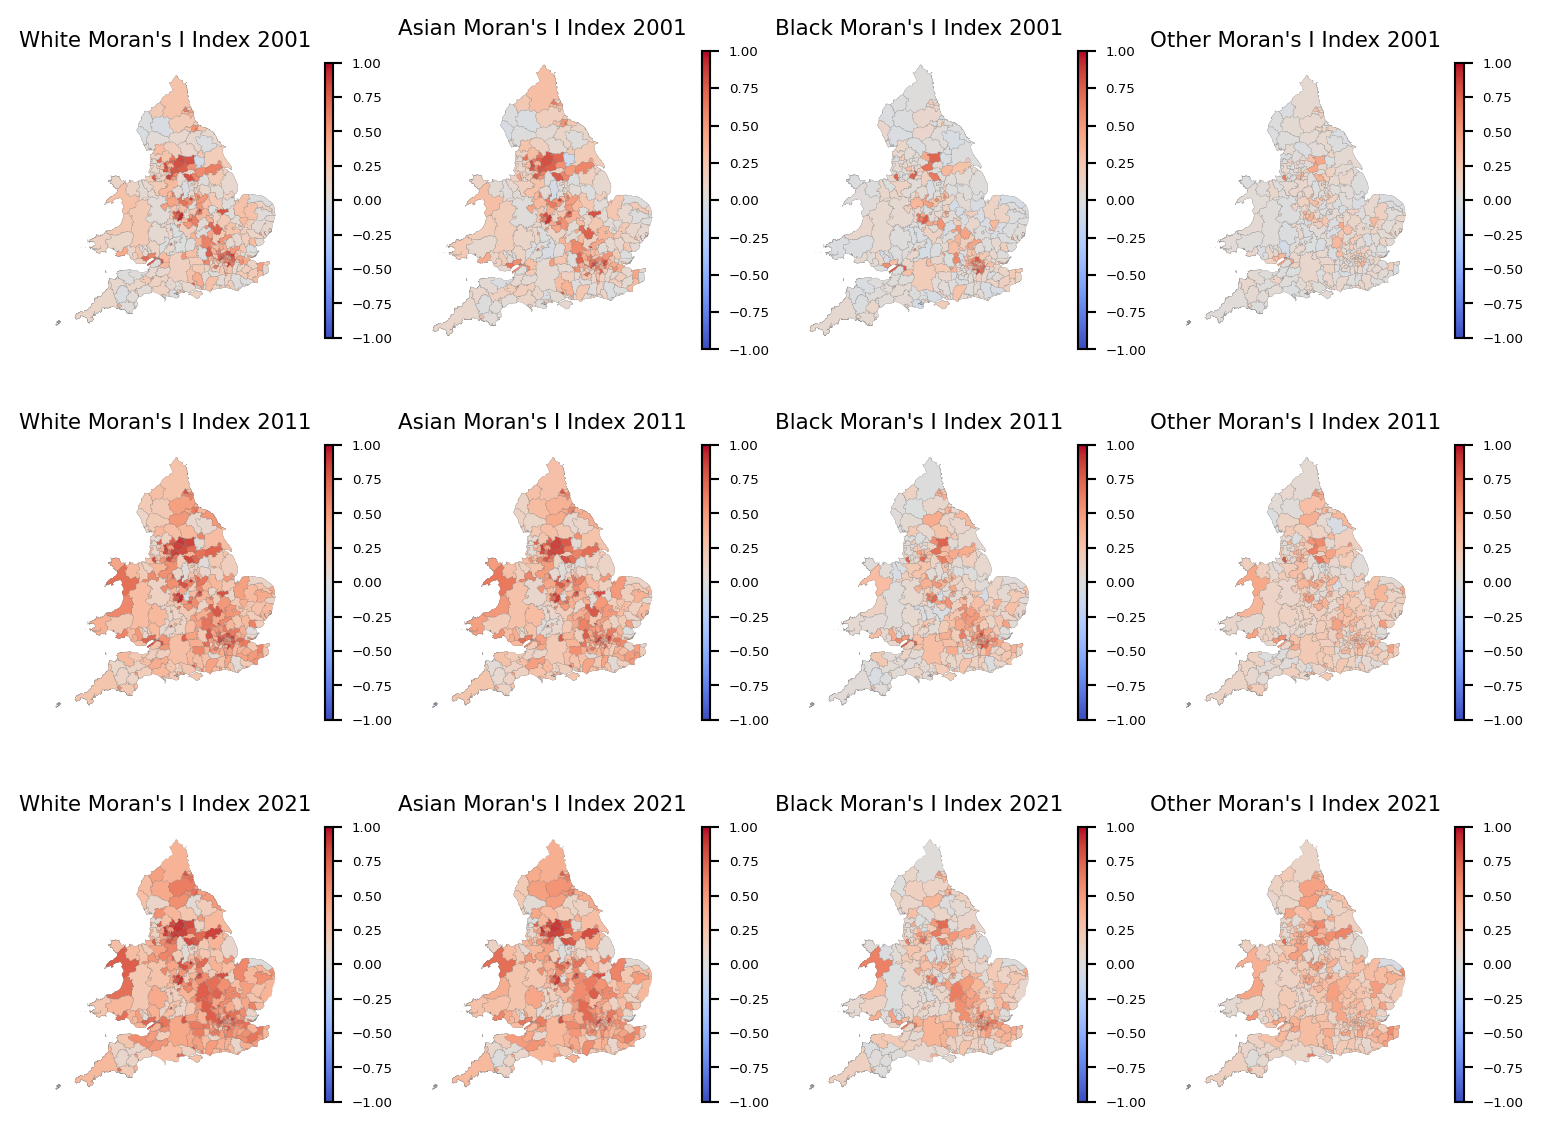

In [32]:
#| echo: false
#| label: fig-moranonxmap
#| fig-cap: OA-based Moran's I in LADs on Map of England

map_data = pd.merge(LAD_moran_total, LAD_total[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

years = [2001, 2011, 2021]

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    ('OA_white_mor', -1, 1, 'White Moran\'s I Index', 'coolwarm'),
    ('OA_asian_mor', -1, 1, 'Asian Moran\'s I Index', 'coolwarm'),
    ('OA_black_mor', -1, 1, 'Black Moran\'s I Index', 'coolwarm'),
    ('OA_other_mor', -1, 1, 'Other Moran\'s I Index', 'coolwarm'),
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = map_data[map_data['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 4 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=0.2)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
    
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=8)
        ax.axis('off')

# fig.suptitle('OA-based Moran\'s I in LADs on Map of England', fontsize=9, y=0.85)

# Adjust layout
plt.subplots_adjust(hspace=-0.5)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Detailed Examination of Segregation in London</span>

In [33]:
#| include: false
london_LAD_indexes = LAD_total[LAD_total.LADCD.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)[1].astype(int).between(9000001,9000034)].reset_index(drop= True)
london_LAD_indexes['total_population']= (london_LAD_indexes['white']+london_LAD_indexes['asian'] + 
                                        london_LAD_indexes['black']+london_LAD_indexes['other'])
cols = list(london_LAD_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
london_LAD_indexes = london_LAD_indexes[cols]
london_LAD_indexes.head()

year      LADCD                 LADNM   white  asian  black  other  \
0  2001  E09000001        City of London    6074    763    169    161   
1  2001  E09000002  Barking and Dagenham  139669   9762  11412   3087   
2  2001  E09000003                Barnet  232876  53226  18871   9440   
3  2001  E09000004                Bexley  199515   9699   6245   2856   
4  2001  E09000005                 Brent  119281  81957  52303   9858   

   total_population  white_frac  asian_frac  ...  MSOA_white_mor  \
0              7167       0.847       0.106  ...             NaN   
1            163930       0.852       0.060  ...           0.519   
2            314413       0.741       0.169  ...           0.553   
3            218315       0.914       0.044  ...           0.414   
4            263399       0.453       0.311  ...           0.738   

   OA_asian_mor  LSOA_asian_mor MSOA_asian_mor  OA_black_mor  LSOA_black_mor  \
0         0.077           0.047            NaN         0.292           0.086   
1         0.624           0.674          0.459         0.557           0.594   
2         0.608           0.590          0.469         0.589           0.576   
3         0.374           0.492          0.450         0.747           0.722   
4         0.775           0.790          0.688         0.668           0.759   

   MSOA_black_mor  OA_other_mor  LSOA_other_mor  MSOA_other_mor  
0             NaN        -0.087           0.085             NaN  
1           0.374         0.192           0.409           0.333  
2           0.424         0.204           0.309           0.286  
3           0.337         0.213           0.415           0.357  
4           0.535         0.129           0.360           0.356  

[5 rows x 45 columns]

In [34]:
#| include: false
# London indexes
london_indexes_2001= pd.read_csv('preprocessed files/2001/london_indexes_2001.csv')
london_indexes_2011= pd.read_csv('preprocessed files/2011/london_indexes_2011.csv')
london_indexes_2021= pd.read_csv('preprocessed files/2021/london_indexes_2021.csv')
london_indexes = pd.concat([london_indexes_2001,london_indexes_2011,london_indexes_2021]).reset_index(drop=True)
london_indexes

year      LADCD   LADNM    white    asian    black    other  \
0  2001  E00000000  London  5103176  1059689   782851   226282   
1  2011  E00000000  London  4887435  1511546  1088640   686320   
2  2021  E00000000  London  4731247  1817652  1188309  1062674   

   total_population  white_frac  asian_frac  ...  MSOA_white_mor  \
0           7171998       0.712       0.148  ...           0.804   
1           8173941       0.598       0.185  ...           0.802   
2           8799882       0.538       0.207  ...           0.776   

   OA_asian_mor  LSOA_asian_mor  MSOA_asian_mor  OA_black_mor  LSOA_black_mor  \
0         0.812           0.856           0.804         0.759           0.803   
1         0.854           0.889           0.848         0.732           0.768   
2         0.832           0.884           0.858         0.663           0.715   

   MSOA_black_mor  OA_other_mor  LSOA_other_mor  MSOA_other_mor  
0           0.793         0.318           0.599           0.728  
1           0.728         0.561           0.737           0.786  
2           0.695         0.530           0.729           0.780  

[3 rows x 41 columns]

In [35]:
#| include: false
# creating London dataframe

london_OA_2001= pd.read_csv('preprocessed files/2001/london_2001.csv')
london_OA_2011= pd.read_csv('preprocessed files/2011/london_2011.csv')
london_OA_2021= pd.read_csv('preprocessed files/2021/london_2021.csv')
london_OA_2001['simp_diff'] = london_OA_2001['OA_simpson']- london_indexes.LAD_simpson[0]
london_OA_2011['simp_diff'] = london_OA_2011['OA_simpson']- london_indexes.LAD_simpson[1]
london_OA_2021['simp_diff'] = london_OA_2021['OA_simpson']- london_indexes.LAD_simpson[2]


london_LSOA_2001= pd.read_csv('preprocessed files/2001/london_LSOA_2001.csv')
london_LSOA_2011= pd.read_csv('preprocessed files/2011/london_LSOA_2011.csv')
london_LSOA_2021= pd.read_csv('preprocessed files/2021/london_LSOA_2021.csv')
london_LSOA_2001['simp_diff'] = london_LSOA_2001['LSOA_simpson']- london_indexes.LAD_simpson[0]
london_LSOA_2011['simp_diff'] = london_LSOA_2011['LSOA_simpson']- london_indexes.LAD_simpson[1]
london_LSOA_2021['simp_diff'] = london_LSOA_2021['LSOA_simpson']- london_indexes.LAD_simpson[2]

london_MSOA_2001= pd.read_csv('preprocessed files/2001/london_MSOA_2001.csv')
london_MSOA_2011= pd.read_csv('preprocessed files/2011/london_MSOA_2011.csv')
london_MSOA_2021= pd.read_csv('preprocessed files/2021/london_MSOA_2021.csv')
london_MSOA_2001['simp_diff'] = london_MSOA_2001['MSOA_simpson']- london_indexes.LAD_simpson[0]
london_MSOA_2011['simp_diff'] = london_MSOA_2011['MSOA_simpson']- london_indexes.LAD_simpson[1]
london_MSOA_2021['simp_diff'] = london_MSOA_2021['MSOA_simpson']- london_indexes.LAD_simpson[2]

london_LAD_2001= pd.read_csv('preprocessed files/2001/london_LAD_2001.csv')
london_LAD_2011= pd.read_csv('preprocessed files/2011/london_LAD_2011.csv')
london_LAD_2021= pd.read_csv('preprocessed files/2021/london_LAD_2021.csv')
london_LAD_2001['simp_diff'] = london_LAD_2001['LAD_simpson']- london_indexes.LAD_simpson[0]
london_LAD_2011['simp_diff'] = london_LAD_2011['LAD_simpson']- london_indexes.LAD_simpson[1]
london_LAD_2021['simp_diff'] = london_LAD_2021['LAD_simpson']- london_indexes.LAD_simpson[2]

london= pd.concat([london_OA_2001,london_OA_2011,london_OA_2021]).reset_index(drop=True)

# Converting the dataframe into GPD
london['geometry'] = london['geometry'].apply(wkt.loads)
london = gpd.GeoDataFrame(london, geometry='geometry')

london_center = {"lat": 51.5072, "lon": -0.1240}


In [36]:
#| include: false
# Creating df for OA level
london_OA = london.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
london_OA.insert(4, 'simp_diff', london_OA.pop('simp_diff'))

london_OA = london_OA.set_crs(epsg=27700)
london_OA = london_OA.to_crs(epsg=4326)

In [37]:
#| include: false
# Creating df for LSOA level
london_LSOA= pd.concat([london_LSOA_2001,london_LSOA_2011,london_LSOA_2021]).reset_index(drop=True)
london_LSOA.insert(3, 'simp_diff', london_LSOA.pop('simp_diff'))

london_LSOA['geometry'] = london_LSOA['geometry'].apply(wkt.loads)
london_LSOA = gpd.GeoDataFrame(london_LSOA, geometry='geometry')

london_LSOA = london_LSOA.set_crs(epsg=27700)
london_LSOA = london_LSOA.to_crs(epsg=4326)

In [38]:
#| include: false
# Creating df for MSOA level
london_MSOA= pd.concat([london_MSOA_2001,london_MSOA_2011,london_MSOA_2021]).reset_index(drop=True)
london_MSOA.insert(3, 'simp_diff', london_MSOA.pop('simp_diff'))

london_MSOA['geometry'] = london_MSOA['geometry'].apply(wkt.loads)
london_MSOA = gpd.GeoDataFrame(london_MSOA, geometry='geometry')

london_MSOA = london_MSOA.set_crs(epsg=27700)
london_MSOA = london_MSOA.to_crs(epsg=4326)

In [39]:
#| include: false
# Creating df for LAD level
london_LAD= pd.concat([london_LAD_2001,london_LAD_2011,london_LAD_2021]).reset_index(drop=True)
london_LAD.insert(3, 'simp_diff', london_LAD.pop('simp_diff'))

london_LAD['geometry'] = london_LAD['geometry'].apply(wkt.loads)
london_LAD = gpd.GeoDataFrame(london_LAD, geometry='geometry')

london_LAD = london_LAD.set_crs(epsg=27700)
london_LAD = london_LAD.to_crs(epsg=4326)

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > Ethnicity and Total Population Line Chart - London </span>

In [40]:
#| echo: false
#| label: fig-lndnethnicpop
#| fig-cap: Ethnicity and Total Population Line Chart - London
# Ethnicity and Total Population Line Chart - London

london_long= london_indexes[['year','white', 'asian', 'black', 'other']].melt(id_vars=['year'], 
                                                                                      var_name='ethnicity',
                                                                                      value_name='population',)

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Ethnicity Population - London", "Total Population - London"),
                     vertical_spacing=0.15)

# Add traces for ethnicity populations
offsets = {
    'white': (10, 30),
    'asian': (10, -10),
    'black': (10, 0),
    'other': (10, 30)
}

for ethnicity in london_long['ethnicity'].unique():
    trace = go.Scatter(
        x=london_long[london_long['ethnicity'] == ethnicity]['year'],
        y=london_long[london_long['ethnicity'] == ethnicity]['population'],
        mode='lines+markers',
        name=ethnicity,
        legendgroup=ethnicity 
    )
    fig.add_trace(trace, row=1, col=1)
    
    # Add annotations with custom offsets for each ethnicity
    for i, row in london_long[london_long['ethnicity'] == ethnicity].iterrows():
        ax, ay = offsets.get(ethnicity, (0, 0)) 
        fig.add_annotation(
            x=row['year'],
            y=row['population'],
            text=f"{row['population']:,}",
            showarrow=True,
            arrowhead=0,
            ax=ax,
            ay=ay,
            font=dict(size=10),
            xanchor='center',
            yanchor='bottom',
            row=1,
            col=1
        )

# Add trace for total population in the second subplot
total_population_trace = go.Scatter(
    x=london_indexes['year'],
    y=london_indexes['total_population'],
    mode='lines+markers',
    name='Total Population',
    line=dict(color='black')
)
fig.add_trace(total_population_trace, row=1, col=2)

# Add annotations for total population
for i, row in london_indexes.iterrows():
    fig.add_annotation(
        x=row['year'],
        y=row['total_population'],
        text=f"{row['total_population']:,}",
        showarrow=True,
        arrowhead=0,
        ax=0,
        ay=-20,
        font=dict(size=10),
        xanchor='center',
        yanchor='bottom',
        row=1,
        col=2
    )

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Ethnicity Population", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Total Population", row=1, col=2)

# Update layout
fig.update_layout(
    height=400, 
    width=1000, 
    # title_text="Ethnicity and Total Population Line Chart - London",
    # title_x=0.5,
    # title_y=0.96,
    showlegend=True,
    legend=dict(orientation="h", yanchor="top", y= 1.28, xanchor="center", x=0.5)
    )

# Display the figure
pyo.iplot(fig)


## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > Ethnic Group Fractions Over Time - London </span>

In [41]:
#| echo: false
#| label: fig-lndnfracoverview
#| fig-cap: Ethnic Group Fractions Over Time - London
# Ethnic Group Fractions Over Time - London

fig = go.Figure()

# Add traces for each ethnic group fraction as stacked bars with percentage annotations outside
fig.add_trace(go.Bar(x=london_indexes['year'], y=london_indexes['white_frac'], 
                     name='White', legendgroup='ethnic_group', width=4, marker=dict(color='gray'),
                     text=london_indexes['white_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))
fig.add_trace(go.Bar(x=london_indexes['year'], y=london_indexes['asian_frac'], 
                     name='Asian', legendgroup='ethnic_group', width=4, marker=dict(color='orange'),
                     text=london_indexes['asian_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))
fig.add_trace(go.Bar(x=london_indexes['year'], y=london_indexes['black_frac'], 
                     name='Black', legendgroup='ethnic_group', width=4, marker=dict(color='black'),
                     text=london_indexes['black_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))
fig.add_trace(go.Bar(x=london_indexes['year'], y=london_indexes['other_frac'], 
                     name='Other', legendgroup='ethnic_group', width=4, marker=dict(color='green'),
                     text=london_indexes['other_frac'] * 100, textposition='inside', 
                     texttemplate='%{text:.2f}%'))

# Update layout
fig.update_layout(width=900,
                  height=500,
                #   title_text="Ethnic Group Fractions Over Time - London ",
                #   title_x=0.5,
                #   title_y=0.9,
                #   title_font=dict(size=16),
                  xaxis_title='Year',
                  xaxis=dict(tickvals=[2001, 2011, 2021]),
                  yaxis_title='Ethnicity Fraction',
                  yaxis=dict(
                      title='Ethnicity Fraction',
                      side='left'),
                  barmode='relative',
                  hovermode='x unified',
                  legend=dict(orientation="h",
                              yanchor="top",
                              y=1.1,
                              xanchor="center",
                              x=0.5,
                              traceorder='normal'))

# Display the figure
pyo.iplot(fig)



## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > OA Simpson Index, White and Asian Fraction and Asian Moran's I on Map </span>

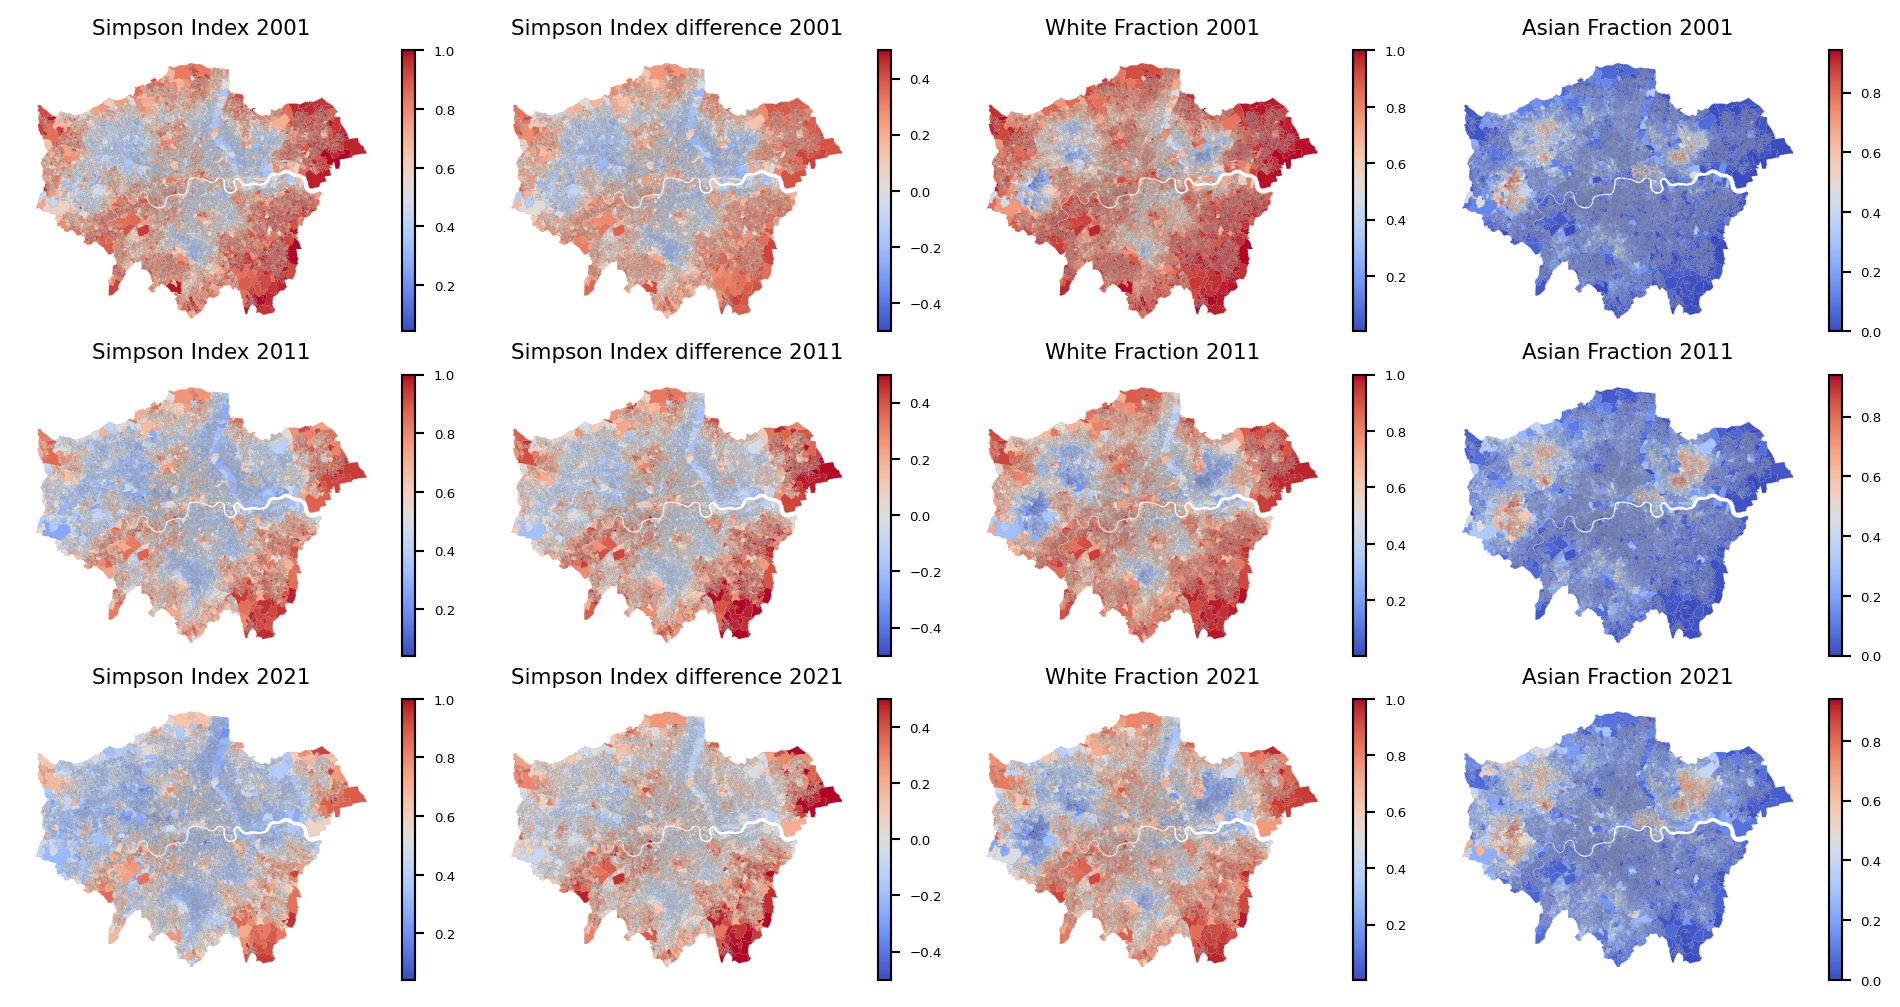

In [42]:
#| echo: false
#| label: fig-oalndnmap
#| fig-cap: OA Simpson Index, White and Asian Fraction and Asian Moran's I on Map - London OAs

years = [2001, 2011, 2021]

oa_simpson_min, oa_simpson_max = london['OA_simpson'].min(), london['OA_simpson'].max()
white_fraction_min, white_fraction_max = london['white_fraction'].min(), london['white_fraction'].max()
asian_fraction_min, asian_fraction_max = london['asian_fraction'].min(), london['asian_fraction'].max()

# Reverse the colormap for the last column
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    ('OA_simpson', oa_simpson_min, oa_simpson_max, 'Simpson Index', 'coolwarm'),
    ('simp_diff', -0.5,0.5, 'Simpson Index difference', 'coolwarm'),
    ('white_fraction', white_fraction_min, white_fraction_max, 'White Fraction', 'coolwarm'),
    ('asian_fraction', asian_fraction_min, asian_fraction_max, 'Asian Fraction', 'coolwarm'),
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = london[london['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 4 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=0.1)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=8)
        ax.axis('off')

# fig.suptitle('OA Simpson Index, OA-LAD Simpson difference, White and Asian Fraction on Map - London OAs', fontsize=10, y= 0.83)

# Adjust layout
plt.subplots_adjust(hspace=-0.7)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > MSOA Simpson Index, MSOA-London Simpson difference, Asian and White Moran's I on Map </span>

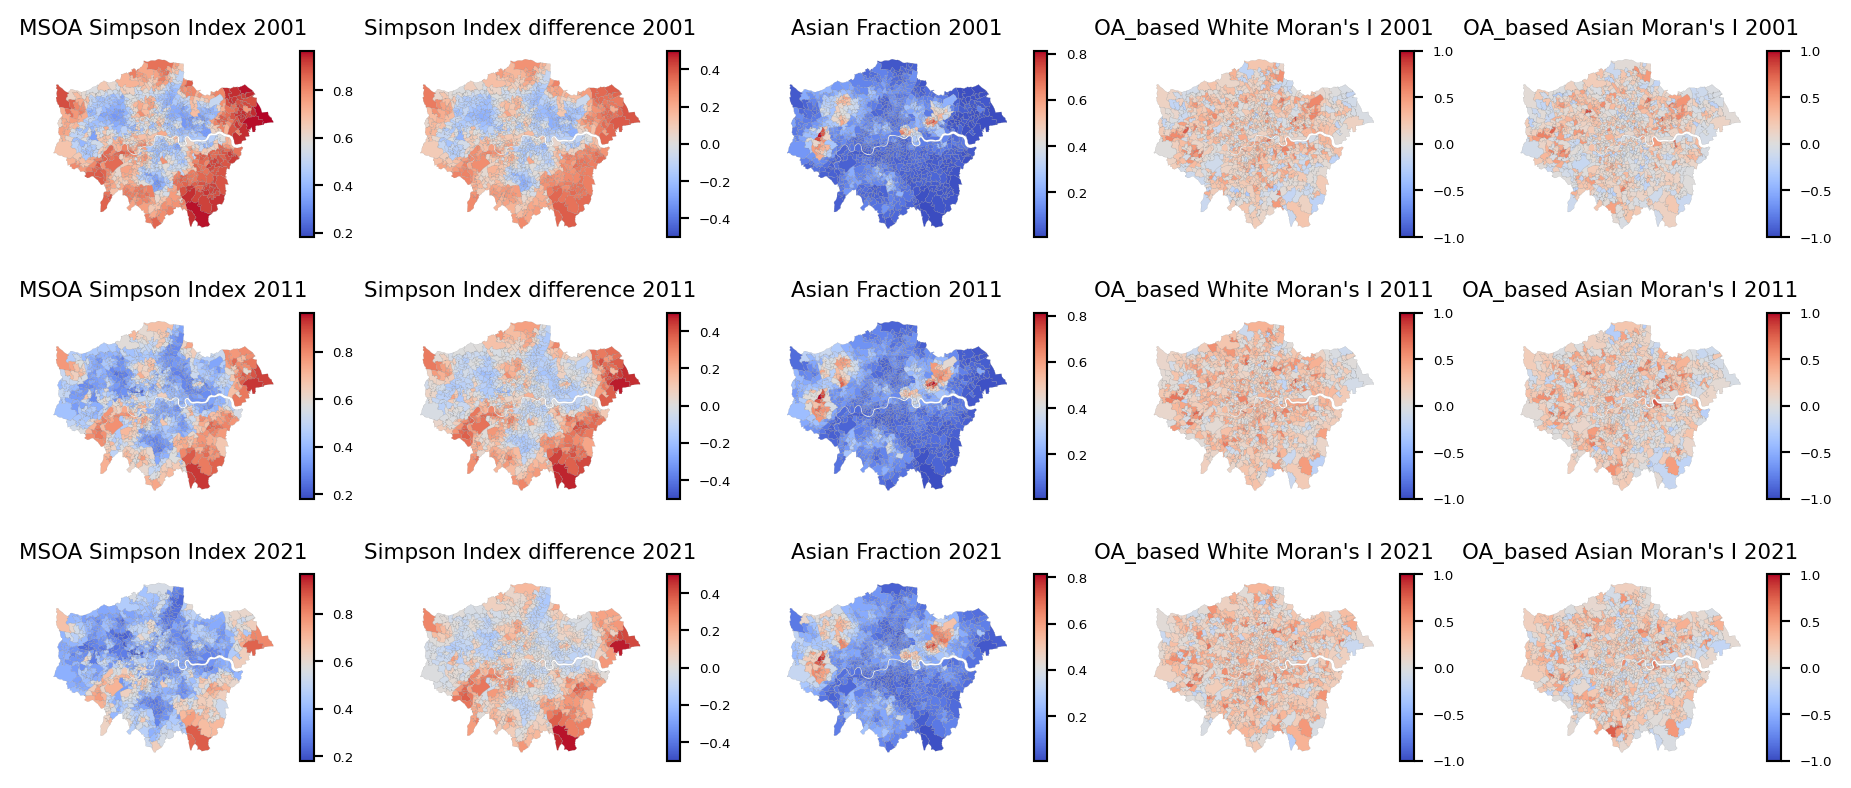

In [43]:
#| echo: false
#| label: fig-msoalndnmap
#| fig-cap: MSOA Simpson Index, MSOA-London Simpson difference, Asian and White Moran's I on Map - London MSOAs

years = [2001, 2011, 2021]

msoa_simpson_min, msoa_simpson_max = london_MSOA['MSOA_simpson'].min(), london_MSOA['MSOA_simpson'].max()
asian_fraction_min, asian_fraction_max = london_MSOA['asian_fraction'].min(), london_MSOA['asian_fraction'].max()

# Reverse the colormap for the last column
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    ('MSOA_simpson', msoa_simpson_min, msoa_simpson_max, 'MSOA Simpson Index', 'coolwarm'),
    ('simp_diff', -0.5,0.5, 'Simpson Index difference', 'coolwarm'),
    ('asian_fraction', asian_fraction_min, asian_fraction_max, 'Asian Fraction', 'coolwarm'),
    ('white_moran_OA', -1, 1, "OA_based White Moran's I", 'coolwarm'),
    ('asian_moran_OA', -1, 1, "OA_based Asian Moran's I", 'coolwarm')
    
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = london_MSOA[london_MSOA['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 5 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=-0.3)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
        
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=8)
        ax.axis('off')

# fig.suptitle('MSOA Simpson Index, MSOA-London Simpson difference, Asian and White Moran\'s I on Map - London MSOAs', 
#              fontsize=9, y=0.73)

# Adjust layout
plt.subplots_adjust(hspace=-0.8)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > LAD Simpson Index, LAD-London Simpson difference, Asian Fraction and Asian and White Moran's I on Map </span>

In [44]:
#| include: false
london_LAD= pd.merge(london_LAD,LAD_moran_total[['LADCD','year','OA_white_mor', 'LSOA_white_mor',
       'MSOA_white_mor', 'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor']], on=['LADCD','year'], how= 'left')

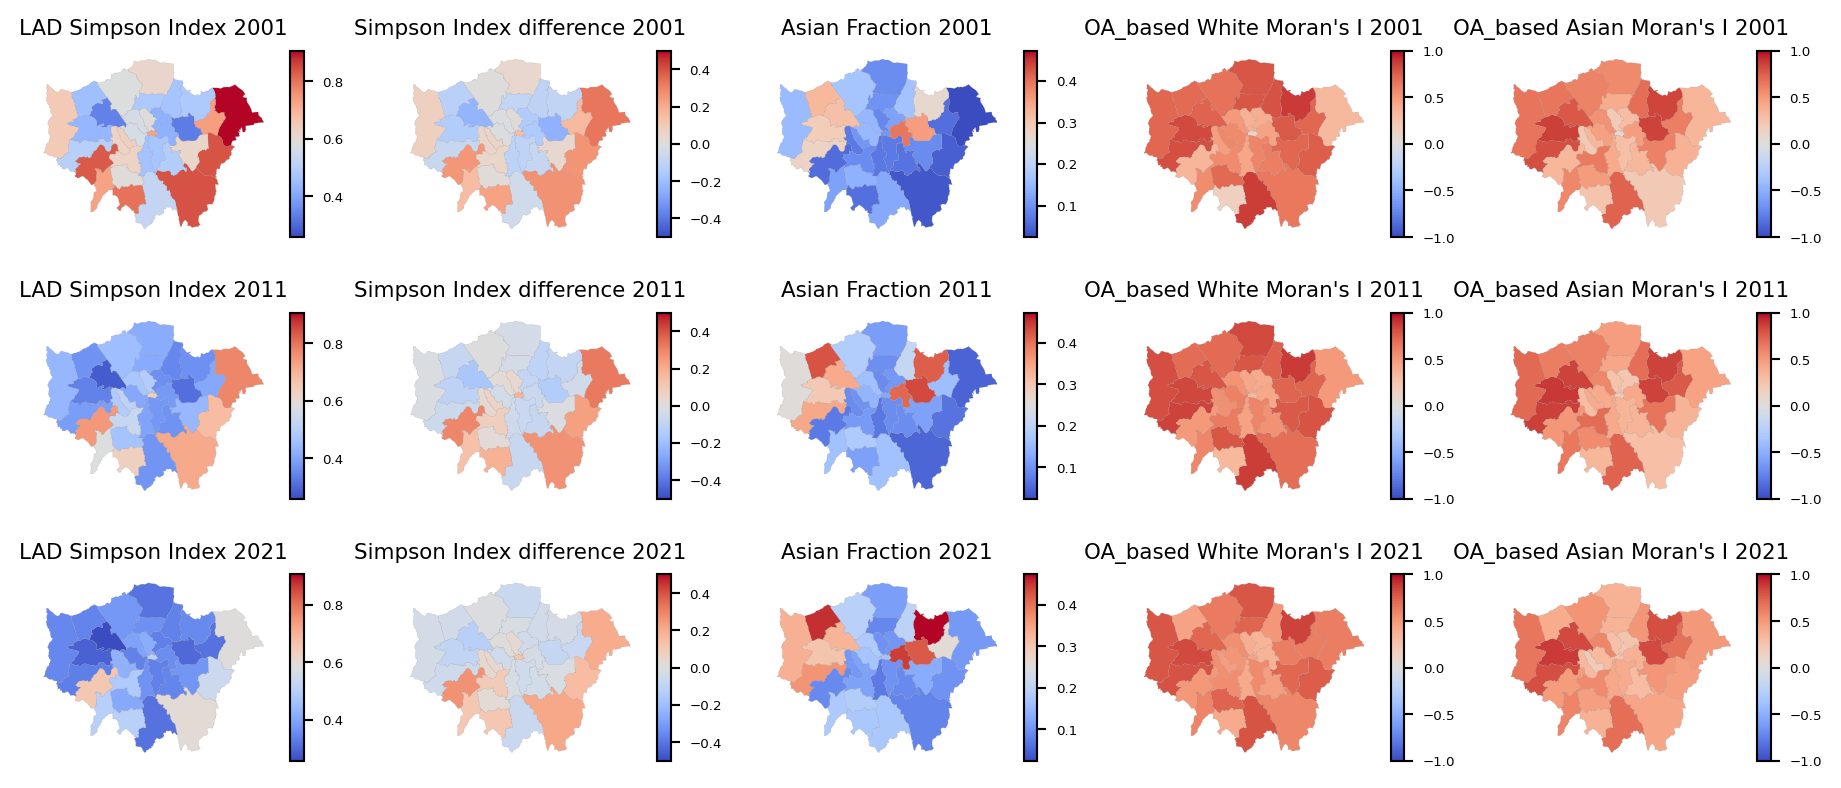

In [45]:
#| echo: false
#| label: fig-ladlndnmap
#| fig-cap: LAD Simpson Index, LAD-London Simpson difference, Asian Fraction and Asian and White Moran's I on Map - London LADs

years = [2001, 2011, 2021]

lad_simpson_min, lad_simpson_max = london_LAD['LAD_simpson'].min(), london_LAD['LAD_simpson'].max()
asian_fraction_min, asian_fraction_max = london_LAD['asian_fraction'].min(), london_LAD['asian_fraction'].max()

# Reverse the colormap for the last column
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    ('LAD_simpson', lad_simpson_min, lad_simpson_max, 'LAD Simpson Index', 'coolwarm'),
    ('simp_diff', -0.5,0.5, 'Simpson Index difference', 'coolwarm'),
    ('asian_fraction', asian_fraction_min, asian_fraction_max, 'Asian Fraction', 'coolwarm'),
    ('OA_white_mor', -1, 1, "OA_based White Moran's I", 'coolwarm'),
    ('OA_asian_mor', -1, 1, "OA_based Asian Moran's I", 'coolwarm')
    
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = london_LAD[london_LAD['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 5 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=-0.3)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
        
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=8)
        ax.axis('off')

# fig.suptitle('LAD Simpson Index, LAD-London Simpson difference, Asian Fraction and Asian and White Moran\'s I on Map - London LADs', 
#              fontsize=9, y=0.73)

# Adjust layout
plt.subplots_adjust(hspace=-0.8)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## <span style="text-align: center; justify-content: center; font-size: 0.9em;" > London Correlations Heatmap </span>

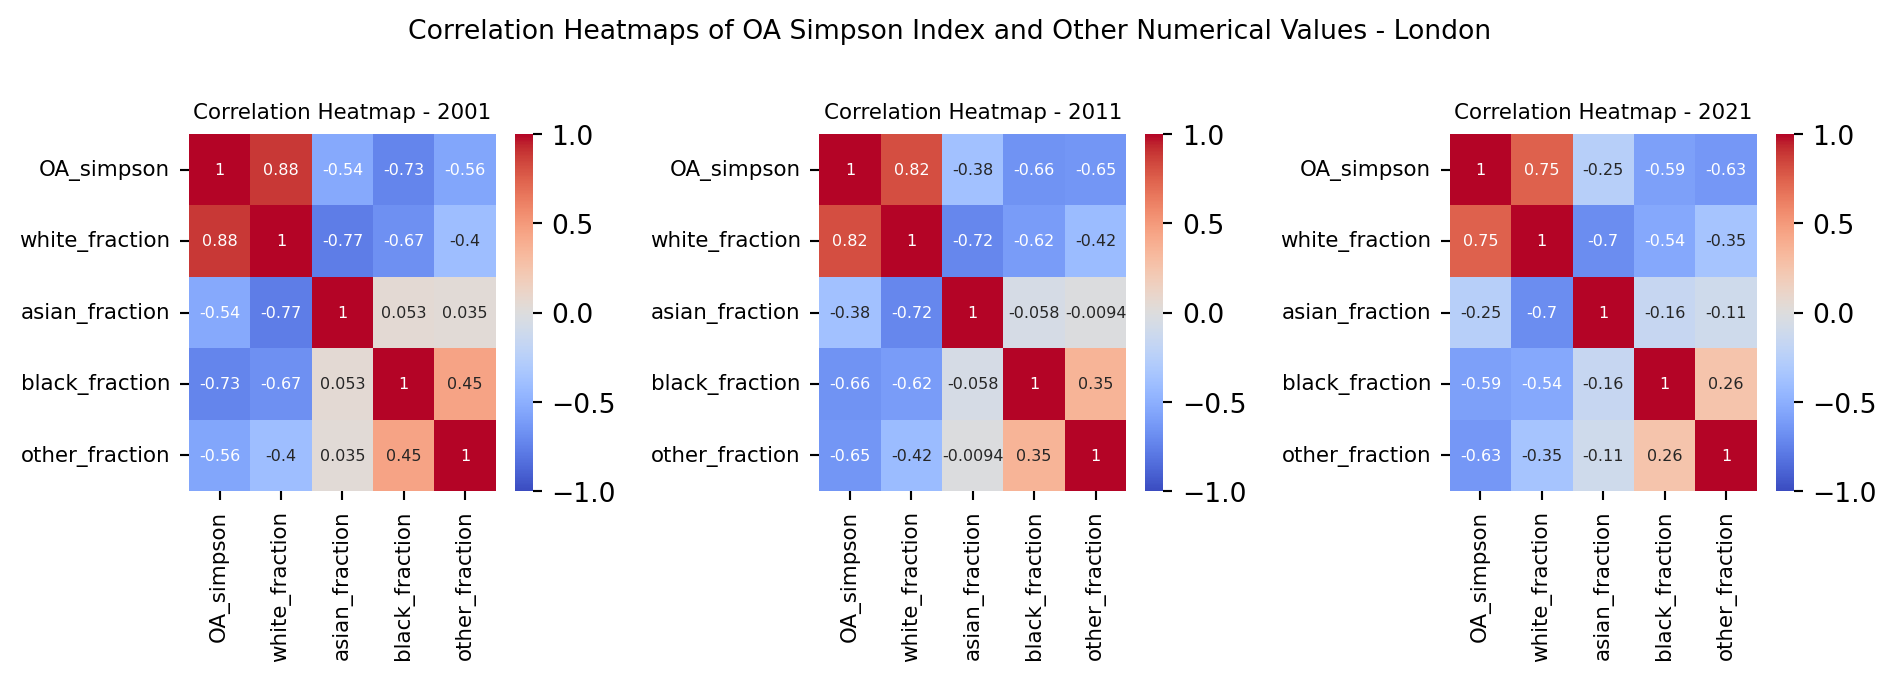

In [46]:
#| echo: false
#| label: fig-lndnheatmap
#| fig-cap: Correlation Heatmap - London
numerical_columns = ['OA_simpson', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction']

years = [2001, 2011, 2021]

correlation_dic = {}
for year in years:
    # Filter data for the specific year
    corr_df = london_OA[london_OA['year'] == year][numerical_columns]
    correlation_matrix = corr_df.corr()
    correlation_dic[year] = correlation_matrix

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

# Plot each heatmap in a subplot
for i, year in enumerate(years):
    ax = axes[i]
    sns.heatmap(correlation_dic[year], annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax, annot_kws={"size": 6})
    ax.set_title(f'Correlation Heatmap - {year}', fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8) 

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Correlation Heatmaps of OA Simpson Index and Other Numerical Values - London', fontsize=10, y=1)
plt.tight_layout()
plt.show()

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Comparing the cities</span>

## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Correlation coefficient between the OA-based Simpson index and the White fraction</span>

<p style="text-align: justify;">
In all cities, the fraction of white ethnicity is predominent and regarding the following table, the correlation between Simpson Index and white ethnicity is positive and rather strong. 
By 2021, this correlation in Leicester turns negative as the Asian ethnic fraction surpasses the White ethnic fraction, resulting in a positive correlation (0.45) with the Asian fraction.
</p>


| Year | Birmingham | Leicester | Bradford | Blackburn | Oldham | Pendle | London |
|------|------------|-----------|----------|-----------|--------|--------|--------|
| 2001 | 0.75       | 0.54      | 0.73     | 0.70      | 0.74   | 0.87   | 0.88   |
| 2011 | 0.66       | 0.20      | 0.65     | 0.61      | 0.58   | 0.81   | 0.82   |
| 2021 | 0.53       | -0.27*    | 0.60     | 0.52      | 0.59   | 0.78   | 0.75   |

In [47]:
#| include: false
birmingham_indexes = LAD_total[LAD_total['LADNM'].str.contains('Birmingham')].reset_index(drop= True)
birmingham_indexes['total_population']= (birmingham_indexes['white']+birmingham_indexes['asian'] + 
                                        birmingham_indexes['black']+birmingham_indexes['other'])
cols = list(birmingham_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
birmingham_indexes = birmingham_indexes[cols]
birmingham_indexes

year      LADCD       LADNM   white   asian   black   other  \
0  2001  E08000025  Birmingham  687386  201959   59784   27928   
1  2011  E08000025  Birmingham  621636  285640   96360   69409   
2  2021  E08000025  Birmingham  556630  355386  125741  107194   

   total_population  white_frac  asian_frac  ...  MSOA_white_mor  \
0            977057       0.704       0.207  ...           0.793   
1           1073045       0.579       0.266  ...           0.820   
2           1144951       0.486       0.310  ...           0.820   

   OA_asian_mor  LSOA_asian_mor MSOA_asian_mor  OA_black_mor  LSOA_black_mor  \
0         0.892           0.878          0.710         0.761           0.835   
1         0.881           0.874          0.727         0.718           0.750   
2         0.868           0.870          0.736         0.685           0.713   

   MSOA_black_mor  OA_other_mor  LSOA_other_mor  MSOA_other_mor  
0           0.774         0.363           0.557           0.545  
1           0.670         0.522           0.676           0.613  
2           0.645         0.449           0.666           0.660  

[3 rows x 45 columns]

In [48]:
#| include: false
leicester_indexes = LAD_total[LAD_total['LADNM'].str.contains('Leicester') & ~LAD_total['LADNM'].str.contains('North West Leicestershire')].reset_index(drop= True)
leicester_indexes['total_population']= (leicester_indexes['white']+leicester_indexes['asian'] + 
                                        leicester_indexes['black']+leicester_indexes['other'])
cols = list(leicester_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
leicester_indexes = leicester_indexes[cols]
leicester_indexes

year      LADCD      LADNM   white   asian  black  other  total_population  \
0  2001  E06000016  Leicester  178693   86044   8576   6519            279832   
1  2011  E06000016  Leicester  166636  122470  20585  20148            329839   
2  2021  E06000016  Leicester  150676  159933  28758  29164            368531   

   white_frac  asian_frac  ...  MSOA_white_mor  OA_asian_mor  LSOA_asian_mor  \
0       0.639       0.307  ...           0.580         0.853           0.803   
1       0.505       0.371  ...           0.643         0.879           0.821   
2       0.409       0.434  ...           0.693         0.897           0.866   

  MSOA_asian_mor  OA_black_mor  LSOA_black_mor  MSOA_black_mor  OA_other_mor  \
0          0.565         0.553           0.464           0.286         0.179   
1          0.637         0.509           0.338           0.160         0.389   
2          0.721         0.524           0.471           0.314         0.260   

   LSOA_other_mor  MSOA_other_mor  
0           0.211          -0.004  
1           0.492           0.213  
2           0.437           0.287  

[3 rows x 45 columns]

In [49]:
#| include: false
bradford_indexes = LAD_total[LAD_total['LADNM'].str.contains('Bradford')].reset_index(drop= True)
bradford_indexes['total_population']= (bradford_indexes['white']+bradford_indexes['asian'] + 
                                        bradford_indexes['black']+bradford_indexes['other'])
cols = list(bradford_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
bradford_indexes = bradford_indexes[cols]
bradford_indexes

year      LADCD     LADNM   white   asian  black  other  total_population  \
0  2001  E08000032  Bradford  366039   90360   4323   6911            467633   
1  2011  E08000032  Bradford  352317  140149   9267  20719            522452   
2  2021  E08000032  Bradford  333985  175651  11005  25775            546416   

   white_frac  asian_frac  ...  MSOA_white_mor  OA_asian_mor  LSOA_asian_mor  \
0       0.783       0.193  ...           0.614         0.810           0.777   
1       0.674       0.268  ...           0.654         0.856           0.810   
2       0.611       0.321  ...           0.666         0.876           0.820   

  MSOA_asian_mor  OA_black_mor  LSOA_black_mor  MSOA_black_mor  OA_other_mor  \
0          0.594         0.413           0.643           0.678         0.277   
1          0.615         0.555           0.680           0.637         0.518   
2          0.629         0.496           0.671           0.701         0.489   

   LSOA_other_mor  MSOA_other_mor  
0           0.463           0.538  
1           0.571           0.632  
2           0.654           0.714  

[3 rows x 45 columns]

In [50]:
#| include: false
blackburn_indexes = LAD_total[LAD_total['LADNM'].str.contains('Blackburn')].reset_index(drop= True)
blackburn_indexes['total_population']= (blackburn_indexes['white']+blackburn_indexes['asian'] + 
                                        blackburn_indexes['black']+blackburn_indexes['other'])
cols = list(blackburn_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
blackburn_indexes = blackburn_indexes[cols]
blackburn_indexes

year      LADCD                  LADNM   white  asian  black  other  \
0  2001  E06000008  Blackburn with Darwen  107113  28736    303   1294   
1  2011  E06000008  Blackburn with Darwen  102009  41494    933   3053   
2  2021  E06000008  Blackburn with Darwen   93408  55174   1397   4782   

   total_population  white_frac  asian_frac  ...  MSOA_white_mor  \
0            137446       0.779       0.209  ...           0.450   
1            147489       0.692       0.281  ...           0.555   
2            154761       0.604       0.357  ...           0.644   

   OA_asian_mor  LSOA_asian_mor MSOA_asian_mor  OA_black_mor  LSOA_black_mor  \
0         0.816           0.665          0.443         0.075           0.229   
1         0.867           0.757          0.546         0.210           0.293   
2         0.901           0.828          0.624         0.359           0.350   

   MSOA_black_mor  OA_other_mor  LSOA_other_mor  MSOA_other_mor  
0           0.360         0.149           0.251           0.527  
1           0.357         0.328           0.498           0.538  
2           0.174         0.352           0.477           0.666  

[3 rows x 45 columns]

In [51]:
#| include: false
oldham_indexes = LAD_total[LAD_total['LADNM'].str.contains('Oldham')].reset_index(drop= True)
oldham_indexes['total_population']= (oldham_indexes['white']+oldham_indexes['asian'] + 
                                        oldham_indexes['black']+oldham_indexes['other'])
cols = list(oldham_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
oldham_indexes = oldham_indexes[cols]
oldham_indexes

year      LADCD   LADNM   white  asian  black  other  total_population  \
0  2001  E08000004  Oldham  187187  26406   1248   2425            217266   
1  2011  E08000004  Oldham  174326  43165   2797   4609            224897   
2  2021  E08000004  Oldham  164900  59558   8201   9397            242056   

   white_frac  asian_frac  ...  MSOA_white_mor  OA_asian_mor  LSOA_asian_mor  \
0       0.862       0.122  ...           0.337         0.773           0.610   
1       0.775       0.192  ...           0.449         0.855           0.715   
2       0.681       0.246  ...           0.578         0.863           0.780   

  MSOA_asian_mor  OA_black_mor  LSOA_black_mor  MSOA_black_mor  OA_other_mor  \
0          0.312         0.180           0.401           0.340         0.218   
1          0.408         0.324           0.431           0.291         0.314   
2          0.512         0.339           0.388           0.155         0.404   

   LSOA_other_mor  MSOA_other_mor  
0           0.359           0.271  
1           0.363           0.296  
2           0.496           0.536  

[3 rows x 45 columns]

In [52]:
#| include: false
pendle_indexes = LAD_total[LAD_total['LADNM'].str.contains('Pendle')].reset_index(drop= True)
pendle_indexes['total_population']= (pendle_indexes['white']+pendle_indexes['asian'] + 
                                        pendle_indexes['black']+pendle_indexes['other'])
cols = list(pendle_indexes.columns)
cols.insert(7, cols.pop(cols.index('total_population')))
pendle_indexes = pendle_indexes[cols]
pendle_indexes

year      LADCD   LADNM  white  asian  black  other  total_population  \
0  2001  E07000122  Pendle  75814  12765    111    631             89321   
1  2011  E07000122  Pendle  71437  16807    126   1082             89452   
2  2021  E07000122  Pendle  67590  25600    242   2372             95804   

   white_frac  asian_frac  ...  MSOA_white_mor  OA_asian_mor  LSOA_asian_mor  \
0       0.849       0.143  ...           0.311         0.664           0.525   
1       0.799       0.188  ...           0.403         0.735           0.655   
2       0.706       0.267  ...           0.432         0.813           0.739   

  MSOA_asian_mor  OA_black_mor  LSOA_black_mor  MSOA_black_mor  OA_other_mor  \
0          0.305         0.047           0.058           0.182         0.088   
1          0.398         0.046           0.131          -0.051         0.221   
2          0.427         0.031           0.252           0.150         0.291   

   LSOA_other_mor  MSOA_other_mor  
0           0.350           0.509  
1           0.480           0.419  
2           0.574           0.455  

[3 rows x 45 columns]

In [53]:
#| include: false
selected_cities = pd.concat(
    [birmingham_indexes.drop(columns=['LAD_pop', 'OA_LAD_diff', 'LSOA_LAD_diff','MSOA_LAD_diff','geometry'], axis = 1), 
    leicester_indexes.drop(columns=['LAD_pop', 'OA_LAD_diff', 'LSOA_LAD_diff','MSOA_LAD_diff','geometry'], axis = 1), 
    bradford_indexes.drop(columns=['LAD_pop', 'OA_LAD_diff', 'LSOA_LAD_diff','MSOA_LAD_diff','geometry'], axis = 1), 
    blackburn_indexes.drop(columns=['LAD_pop', 'OA_LAD_diff', 'LSOA_LAD_diff','MSOA_LAD_diff','geometry'], axis = 1), 
    oldham_indexes.drop(columns=['LAD_pop', 'OA_LAD_diff', 'LSOA_LAD_diff','MSOA_LAD_diff','geometry'], axis = 1), 
    pendle_indexes.drop(columns=['LAD_pop', 'OA_LAD_diff', 'LSOA_LAD_diff','MSOA_LAD_diff','geometry'], axis = 1),
    london_indexes.drop(columns=['London_simpson'], axis = 1)]).reset_index(drop=True)


## <span style="text-align: center; justify-content: center; font-size: 0.9em;" >Indices Trends in Selected English Cities (2001-2021)</span>

In [54]:
#| echo: false
#| label: fig-citytrend
#| fig-cap: Indices Trends in Selected English Cities (2001-2021)

# Extend the color list
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3','#FF6692']

# Create subplots
fig = make_subplots(rows=4, cols=2, subplot_titles=('White Fraction', 'Asian Fraction',
                                                    'White OA-based Dissimilarity','Asian OA-based Dissimilarity',
                                                    'OA-based Simpsom', 'LAD-based Simpsom',
                                                    'White Moran\'s I ','Asian Moran\'s I'),
                    vertical_spacing=0.08, horizontal_spacing=0.05,
                    row_heights=[0.3, 0.3, 0.3,0.3])


# Plot White fraction trend
for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['white_frac'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=True), row=1, col=1)

# Plot Asian fraction trend
for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['asian_frac'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=1, col=2)

for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['OA_white_diss'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=2, col=1)

for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['OA_asian_diss'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=2, col=2)

for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['OA_simpson'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=3, col=1)

for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['LAD_simpson'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=3, col=2)
    
for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['OA_white_mor'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=4, col=1)

for i, city in enumerate(selected_cities.LADNM.unique()):
    city_data = selected_cities[selected_cities['LADNM'] == city]
    fig.add_trace(go.Scatter(x=city_data['year'], y=city_data['OA_asian_mor'], mode='lines+markers', 
                             name=city, line=dict(color=colors[i]), showlegend=False), row=4, col=2)

# Update layout
fig.update_layout(height=1100, width=850,
                #   title_text="Indices Trends in Selected English Cities (2001-2021)", 
                #   title_x=0.5,
                #   title_y=0.99,
                  legend=dict(orientation="h",y= 1.09, xanchor="center", x=0.5))
fig.update_xaxes(tickvals=[2001, 2011, 2021])

# Show plot
fig.show()

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Conclusion</span>

- **Comprehensive Analysis**: Segregation indexes examined at country, LAD, and city levels in England.

- **Dissimilarity Index Trends**: Decrease in values for White, Asian and Black ethnicities, indicating increased integration.

- **Simpson Index Findings**: Higher values in homogeneous OAs; overall diversity balanced out across all OAs.

- **Spatial Scale Effects**: Higher Moran's I at local scales (OAs) vs. broader scales (LSOAs).

- **Overall Trends (2001-2021)**: Positive movement towards greater ethnic cohesion and reduced segregation; persistent localized clustering at OA level.
</span>

## References {.section}